In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pickle
import tensorflow as tf
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph
from skimage.transform import rotate
from tensorflow.keras.datasets import cifar10
import tensorflow_datasets as tfds
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import layers, models
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
!pip install bctpy
!pip install brainspace

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.4/110.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 48.9 MB/s eta 0:00:00


In [10]:
import bct
from brainspace.gradient.embedding import diffusion_mapping

In [25]:
import numpy as np
from sklearn.neighbors import kneighbors_graph

def normalize_distances(distances, method='minmax', temperature=1.0):
    """Normalize distances using the specified method, including temperature for softmax."""
    if method == 'minmax':
        # Min-Max normalization
        min_val = distances.min()
        max_val = distances.max()
        normalized = (distances - min_val) / (max_val - min_val)
    elif method == 'softmax':
        # Softmax normalization with temperature
        exp_distances = np.exp(-distances / temperature)
        normalized = exp_distances / exp_distances.sum()
    else:
        raise ValueError("Unsupported normalization method. Choose 'minmax' or 'softmax'.")

    return normalized

def apply_transformation(distances, transform='inverse_exp', decay_factor=5):
    """Transform distances to weights using the specified method."""
    if transform == 'inverse_exp':
        weights = np.exp(-decay_factor * distances)
    elif transform == 'sigmoid':
        # Apply sigmoid with adjustable scaling and shifting
        weights = 1 / (1 + np.exp(5 * distances - 2.5))
    else:
        raise ValueError("Unsupported transformation method. Choose 'inverse_exp' or 'sigmoid'.")

    return weights

def compute_custom_knn_adjacency(data, n_neighbors, norm_method='minmax', transform_method='inverse_exp', temperature=1.0,decay_factor = 5.0):
    """
    Compute a k-nearest neighbor graph with customizable normalization and transformation methods.

    :param data: The input data matrix.
    :param n_neighbors: Number of nearest neighbors to consider.
    :param norm_method: 'minmax' or 'softmax' for distance normalization.
    :param transform_method: 'inverse_exp' or 'sigmoid' for distance-to-weight conversion.
    :param temperature: Temperature parameter for softmax normalization.
    :return: A sparse adjacency matrix.
    """
    # Create kNN graph in 'distance' mode
    adjacency = kneighbors_graph(data, n_neighbors, mode='distance', metric='minkowski', p=2)
    adjacency = (adjacency + adjacency.T) / 2

    # Normalize the distances
    normalized_distances = normalize_distances(adjacency.data, method=norm_method, temperature=temperature)

    # Transform the normalized distances to weights
    adjacency.data = apply_transformation(normalized_distances,
                                          transform=transform_method,
                                          decay_factor=decay_factor)

    return adjacency


In [53]:
def load_cifar10():
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    return (X_train, y_train), (X_test, y_test)

def load_mnist():
    # Load data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Reshape data to add channel dimension
    X_train = np.expand_dims(X_train, -1)
    X_test = np.expand_dims(X_test, -1)

    # Normalize data
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

    return (X_train, y_train), (X_test, y_test)

import numpy as np
from scipy.sparse import csr_matrix
from sklearn.cluster import SpectralClustering

def spectral_clustering_sparse(adj_matrix, n_clusters):
    """
    Compute spectral clustering on a sparse graph.

    :param adj_matrix: Sparse adjacency matrix (CSR format preferred).
    :param n_clusters: Desired number of clusters.
    :return: 1D array of cluster assignments for each node.
    """
    # Ensure the adjacency matrix is symmetric
    if (adj_matrix != adj_matrix.T).nnz == 0:
        symmetric_adj_matrix = adj_matrix
    else:
        symmetric_adj_matrix = adj_matrix.maximum(adj_matrix.T)

    # Convert the sparse matrix to a dense array if it isn't too large
    dense_adj_matrix = symmetric_adj_matrix.toarray()

    # Apply spectral clustering
    clustering = SpectralClustering(
        n_clusters=n_clusters,
        affinity='precomputed',
        assign_labels='kmeans',
        random_state=42
    )
    cluster_labels = clustering.fit_predict(dense_adj_matrix)

    return cluster_labels



def estimate_modularity_proxy_sampled(adj_matrix: sp.csr_matrix, clusters: np.ndarray, sample_size: int = 1000) -> float:
    """
    Estimate a modularity proxy with node sampling for faster computation.

    :param adj_matrix: Sparse adjacency matrix in CSR format.
    :param clusters: 1D array of cluster assignments (cluster labels) for each node.
    :param sample_size: The number of nodes to sample for the approximation.
    :return: An estimated modularity score.
    """
    num_nodes = adj_matrix.shape[0]

    # Ensure the sample size does not exceed the total number of nodes
    sample_size = min(sample_size, num_nodes)

    # Randomly sample node indices
    sampled_indices = np.random.choice(num_nodes, sample_size, replace=False)
    sampled_clusters = clusters[sampled_indices]

    # Create a subgraph using the sampled nodes
    sampled_adj_matrix = adj_matrix[sampled_indices, :][:, sampled_indices]

    # Create a one-hot encoding of cluster assignments for sampled nodes
    sampled_num_clusters = len(np.unique(sampled_clusters))
    membership_matrix = sp.csr_matrix(
        (np.ones(sample_size), (np.arange(sample_size), sampled_clusters)),
        shape=(sample_size, sampled_num_clusters)
    )

    # Calculate intra-cluster weights within the sampled subgraph
    intra_cluster_weights = membership_matrix.T @ sampled_adj_matrix @ membership_matrix
    observed_intra_cluster_ratio = intra_cluster_weights.diagonal().sum() / sampled_adj_matrix.sum()

    # Estimate the expected intra-cluster weights assuming a random distribution in the sample
    sampled_cluster_sizes = np.array(membership_matrix.sum(axis=0)).flatten()
    expected_intra_cluster_ratio = np.sum((sampled_cluster_sizes / sample_size) ** 2)

    # Approximate modularity based on the sampled subgraph
    modularity_proxy = observed_intra_cluster_ratio - expected_intra_cluster_ratio

    return modularity_proxy


def compute_graph_degree_moments(data,n_neighbors = 100,adj = None):
    if data is not None:
      adj = compute_custom_knn_adjacency(data, n_neighbors)
    degree = np.sum(adj, axis = 1)
    mu = np.mean(degree)
    var = ss.median_abs_deviation(degree)
    skew = ss.skew(degree)
    kurt = ss.kurtosis(degree)
    return mu, var, skew, kurt


def eval_ratio(evals):
    return evals[0]/np.sum(evals)

def dispersion_centroid(vecs,use_mean=False):
    """
    Compute the dispersion of a set of vectors around their centroid.

    Parameters:
    - vecs (numpy.ndarray): Input vectors.

    Returns:
    - float: Dispersion value.
    """

    centroid = vecs.mean(axis=0)
    dists = np.linalg.norm(vecs - centroid, axis=1)
    if use_mean:
        disp = np.mean(dists)
    else:
        disp = np.median(dists)


    return disp

def compute_graph_metrics(features,n_neighbors=100,plot_difemb=True):
    adjacency = compute_custom_knn_adjacency(features,n_neighbors)
    mean_deg, var_deg, skew_deg, kurt_deg = compute_graph_degree_moments(None, n_neighbors, adjacency)
    charpath, effs, eccs, rad, diam = bct.charpath(adjacency.toarray())
    #clustcoefs = bct.clustering_coef_wu(adjacency.toarray())
    difemb, difvals = diffusion_mapping(adjacency)
    if plot_difemb:
      plt.figure()
      plt.scatter(difemb[:,0],difemb[:,1],s=0.5)
      plt.xlabel('DE1')
      plt.ylabel('DE2')
      plt.title('feature nn graph diffusion embedding')
      plt.show()
    dispersion = dispersion_centroid(difemb)
    ev_ratio = difvals[0]/np.sum(difvals)
    clusters = spectral_clustering_sparse(adjacency, 10)
    modularity = estimate_modularity_proxy_sampled(adjacency, clusters)

    graph_metrics = [mean_deg, var_deg[0], skew_deg[0], kurt_deg[0], charpath, rad, dispersion,ev_ratio,modularity]
    #graph_metrics = [mean_deg, var_deg[0], skew_deg[0], kurt_deg[0], charpath, rad]
    #graph_metrics = [mean_deg, var_deg[0], skew_deg[0], kurt_deg[0]]


    return np.array(graph_metrics)

graph_metrics_names = ['degree mean','degree variance','degree skewness',
                       'degree kurtosis','characteristic path length',
                       'graph radius', 'diffusion embedding dispersion',
                       'diffusion embedding eigenvalue ratio','modularity']


def extract_features(model, data):
    # Create a new model that will output the features from the penultimate layer of the original model
    intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)

    # Now, instead of predicting sample by sample, we can predict in batches
    features = intermediate_layer_model.predict(data,batch_size = 256)

    # Flatten the features if necessary. Since we're using the output of a Dense layer, it should already be 2D (samples, features).
    # If you were taking features from a layer that outputs higher-dimensional data, you might need to flatten it.

    return features

from scipy.stats import entropy

# Function to calculate entropy for a set of prediction probabilities
def calculate_entropy(predictions):
    return np.array([entropy(pred) for pred in predictions])


model_names = ['simple_model', 'slightly_complex_model', 'complex_dropout_model',
               'complex_dropout_bn_model','lenet_variant_model','my_variant_model',
               'model1','model2','model3','model4','model5',
               'optimal_ood_model','densenet_like_model',
               'vgg_like','mobilenet_like','shallow_wide',
               'asymmetric_conv','minimalistic','high_dropout','increased_bn',
               'extreme_resnet','large_kernel_model','skip_connection_model',
               'dense_prediction_model'
               ,'resnet_lite_model','multi_scale_features_model',
               'dual_path_network_model','inception_like','deep_simple_model']#'triple_depth_normalized_cnn'

print(f'total number of models = {len(model_names)}')



total number of models = 29


In [7]:
import matplotlib.pyplot as plt

def plot_adjacency_histogram(adj, bins=50):
    """
    Plot a histogram of the non-zero values in the adjacency matrix.

    :param adj: A sparse.csr_matrix representing the adjacency matrix.
    :param bins: Number of bins for the histogram.
    """
    # Extract non-zero values
    values = adj.data

    # Plot histogram
    plt.hist(values, bins=bins, edgecolor='black')
    plt.xlabel('Edge Weights')
    plt.ylabel('Frequency')
    plt.title('Histogram of Adjacency Matrix Edge Weights')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()


40/40 [==============================] - 1s 19ms/step


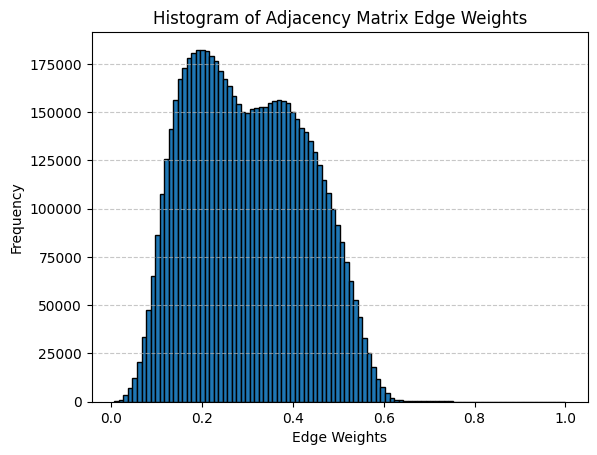

/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


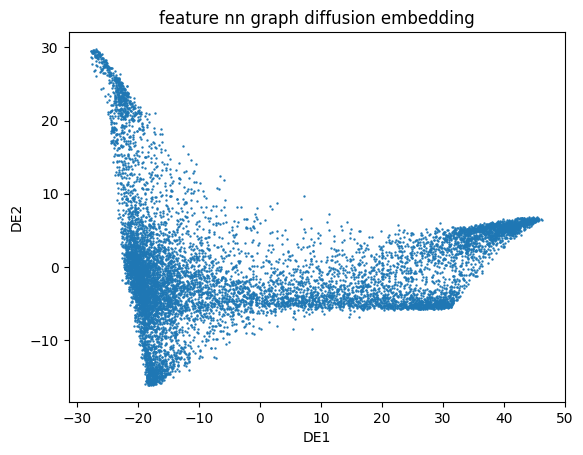

degree mean 202.07618972747403
degree variance 42.03655705199354
degree skewness 1.8294851874447462
degree kurtosis 5.392178579454297
characteristic path length 0.020209639936741085
graph radius 0.15766116641577754
diffusion embedding dispersion 22.293172877853983
diffusion embedding eigenvalue ratio 0.4065526845847804
modularity 0.5317833065776082


In [54]:
model = load_model(f'/content/drive/My Drive/ood_generalization_proj/cnn_models/{model_names[1]}.keras', safe_mode=False)

features = extract_features(model, X_test)

adj = compute_custom_knn_adjacency(features, 500,norm_method='minmax',decay_factor=5)

plot_adjacency_histogram(adj,100)

gm = compute_graph_metrics(features, 500)
for m, n in zip (gm, graph_metrics_names):
    print(n, m)

In [52]:
clusters = spectral_clustering_sparse(adj,10)

In [51]:
mod = estimate_modularity_proxy_sampled(adj, clusters)
print(mod)

0.5110041430233077


In [4]:
(X_train, y_train), (X_test, y_test) = load_cifar10()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data()

# Step 2: Normalize the pixel values of the images
X_train_100 = train_images.astype("float32") / 255.0
X_test_100 = test_images.astype("float32") / 255.0

del train_images
del test_images


169001437/169001437 [==============================] - 2s 0us/step


In [6]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data()

# Step 2: Normalize the pixel values of the images
X_train_100 = train_images.astype("float32") / 255.0
X_test_100 = test_images.astype("float32") / 255.0

del train_images
del test_images

In [55]:
corrupted_test_data, info = tfds.load('cifar10_corrupted/elastic_4', with_info=True, split='test')
def preprocess_data(sample):
    image = tf.image.resize(sample['image'], (32, 32))
    image = tf.cast(image, tf.float32) / 255.0
    label = sample['label']
    return image, label

corrupted_test_data = corrupted_test_data.map(preprocess_data)
x_corrupted_test, y_corrupted_test = [], []

for image, label in corrupted_test_data.take(10000):
    x_corrupted_test.append(image)
    y_corrupted_test.append(label)

x_corrupted_test = tf.convert_to_tensor(x_corrupted_test)
y_corrupted_test = tf.convert_to_tensor(y_corrupted_test)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10_corrupted/elastic_4/1.0.0.incompleteGOUMXY/cifar10_corrupted-test.…

Dataset cifar10_corrupted downloaded and prepared to /root/tensorflow_datasets/cifar10_corrupted/elastic_4/1.0.0. Subsequent calls will reuse this data.


In [56]:
del corrupted_test_data


In [57]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf

# Function to resize and convert to grayscale
def preprocess_image(image, label):
    # Convert to grayscale by averaging across color channels
    grayscale_image = tf.image.rgb_to_grayscale(image)
    # Resize to 28x28 pixels
    resized_image = tf.image.resize(grayscale_image, [28, 28])
    return resized_image, label

# Load the SVHN test dataset and apply the preprocessing function
svhn_test = tfds.load('svhn_cropped', split='test', as_supervised=True)
svhn_test = svhn_test.map(preprocess_image)

# Take 10,000 examples
x_svhn_test_list, y_svhn_test_list = [], []
for image, label in svhn_test.take(10000):
    x_svhn_test_list.append(image.numpy())
    y_svhn_test_list.append(label.numpy())

# Convert lists to numpy arrays
x_svhn_test = np.stack(x_svhn_test_list).astype(np.float32) / 255.0  # Normalize to [0, 1]
y_svhn_test = np.array(y_svhn_test_list)

# Ensure shape is (10000, 28, 28, 1) for grayscale
x_svhn_test = x_svhn_test.reshape(-1, 28, 28, 1)

# Print shapes to confirm
print("x_svhn_test shape:", x_svhn_test.shape)
print("y_svhn_test shape:", y_svhn_test.shape)

del svhn_test
del x_svhn_test_list
del y_svhn_test_list

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/73257 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteLAMKZ1/svhn_cropped-train.tfrecord*...:   0%|…

Generating test examples...:   0%|          | 0/26032 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteLAMKZ1/svhn_cropped-test.tfrecord*...:   0%| …

Generating extra examples...:   0%|          | 0/531131 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteLAMKZ1/svhn_cropped-extra.tfrecord*...:   0%|…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.0.0. Subsequent calls will reuse this data.
x_svhn_test shape: (10000, 28, 28, 1)
y_svhn_test shape: (10000,)


In [58]:
from tensorflow.keras.datasets import fashion_mnist

def load_fashion_mnist():
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    X_train = np.expand_dims(X_train, -1)  # Reshape to add channel dimension
    X_test = np.expand_dims(X_test, -1)
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    return (X_train, y_train), (X_test, y_test)

(X_train_fashion, y_train_fashion), (X_test_fashion, y_test_fashion) = load_fashion_mnist()

4422102/4422102 [==============================] - 0s 0us/step


In [59]:
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = load_mnist()

11490434/11490434 [==============================] - 0s 0us/step


In [60]:
from sklearn.model_selection import train_test_split
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1 - 0.1, random_state=42)
X_train_subset_mnist, _, y_train_subset_mnist, _ = train_test_split(X_train_mnist, y_train_mnist, test_size=1 - 0.1, random_state=42)


In [61]:
cifar_graph_metrics = []

for name in model_names:
    print(name)
    model = load_model(f'/content/drive/My Drive/ood_generalization_proj/cnn_models/{name}.keras', safe_mode=False)
    cifar_features = extract_features(model, X_train_subset)
    print(cifar_features.shape)
    #np.save(f'/content/drive/My Drive/ood_generalization_proj/cnn_models/{name}_features.npy',cifar_features)
    cifar_graph_metrics.append(compute_graph_metrics(cifar_features,plot_difemb=False,n_neighbors = 500))

np.save('/content/drive/My Drive/ood_generalization_proj/cifar_graph_metrics.npy',np.array(cifar_graph_metrics))

simple_model
20/20 [==============================] - 0s 13ms/step
(5000, 10)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


slightly_complex_model
20/20 [==============================] - 0s 19ms/step
(5000, 10)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


complex_dropout_model
20/20 [==============================] - 0s 15ms/step
(5000, 10)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


complex_dropout_bn_model
20/20 [==============================] - 1s 31ms/step
(5000, 10)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


lenet_variant_model
20/20 [==============================] - 0s 8ms/step
(5000, 10)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


my_variant_model
20/20 [==============================] - 0s 9ms/step
(5000, 10)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


model1
20/20 [==============================] - 1s 33ms/step
(5000, 10)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


model2
20/20 [==============================] - 1s 32ms/step
(5000, 10)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


model3
20/20 [==============================] - 1s 31ms/step
(5000, 10)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


model4
20/20 [==============================] - 0s 20ms/step
(5000, 10)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


model5
20/20 [==============================] - 1s 56ms/step
(5000, 10)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


optimal_ood_model
20/20 [==============================] - 1s 56ms/step
(5000, 10)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


densenet_like_model
20/20 [==============================] - 6s 288ms/step
(5000, 256)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


vgg_like
20/20 [==============================] - 2s 84ms/step
(5000, 256)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


mobilenet_like
20/20 [==============================] - 0s 10ms/step
(5000, 128)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


shallow_wide
20/20 [==============================] - 4s 184ms/step
(5000, 256)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


asymmetric_conv
20/20 [==============================] - 2s 89ms/step
(5000, 256)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


minimalistic
20/20 [==============================] - 0s 6ms/step
(5000, 7200)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


high_dropout
20/20 [==============================] - 2s 76ms/step
(5000, 256)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


increased_bn
20/20 [==============================] - 1s 58ms/step
(5000, 128)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


extreme_resnet
20/20 [==============================] - 24s 1s/step
(5000, 256)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


large_kernel_model
20/20 [==============================] - 0s 15ms/step
(5000, 256)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


skip_connection_model
20/20 [==============================] - 2s 81ms/step
(5000, 256)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


dense_prediction_model
20/20 [==============================] - 1s 56ms/step
(5000, 256)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


resnet_lite_model
20/20 [==============================] - 2s 70ms/step
(5000, 256)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


multi_scale_features_model
20/20 [==============================] - 1s 54ms/step
(5000, 256)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


dual_path_network_model
20/20 [==============================] - 2s 87ms/step
(5000, 256)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


inception_like
20/20 [==============================] - 3s 133ms/step
(5000, 256)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


deep_simple_model
20/20 [==============================] - 1s 26ms/step
(5000, 10)


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


In [62]:
mnist_graph_metrics = []
for name in model_names:
    mnist_model = load_model(f'/content/drive/My Drive/ood_generalization_proj/cnn_models/MNIST_models/{name}.keras', safe_mode=False)
    mnist_features = extract_features(mnist_model, X_train_subset_mnist)
    #np.save(f'/content/drive/My Drive/ood_generalization_proj/cnn_models/MNIST_models/{name}_features.npy',mnist_features)
    mnist_graph_metrics.append(compute_graph_metrics(mnist_features,plot_difemb=False,n_neighbors = 500))

np.save('/content/drive/My Drive/ood_generalization_proj/mnist_graph_metrics.npy',np.array(mnist_graph_metrics))


24/24 [==============================] - 0s 9ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 0s 12ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 0s 11ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 0s 7ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 1s 20ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 1s 20ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 1s 19ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 0s 14ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 1s 36ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 1s 36ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 6s 219ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 1s 54ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 3s 143ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 2s 67ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 1s 58ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 1s 41ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 22s 896ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 0s 13ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 1s 53ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 1s 38ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 2s 54ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 1s 33ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 1s 59ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 2s 97ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


24/24 [==============================] - 0s 14ms/step


/usr/local/lib/python3.10/dist-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


In [63]:
from sklearn.metrics import roc_auc_score, f1_score

# Lists for storing metrics
cifar_auroc_scores = []
cifar_ood_accuracy = []
cifarc_entropy = []
cifar100_entropy = []
cifar_id_test_accuracy = []
cifar_id_entropy = []


# Separated loops for CIFAR and MNIST model processing
# CIFAR loop
for name in model_names:
    model_path = f'/content/drive/My Drive/ood_generalization_proj/cnn_models/{name}.keras'
    model = load_model(model_path, safe_mode=False)
    print(f'{name} (CIFAR) loaded')

    # Evaluations
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    cifar_id_test_accuracy.append(test_acc)
    loss, accuracy = model.evaluate(x_corrupted_test, y_corrupted_test, verbose=0,batch_size=256)
    cifar_ood_accuracy.append(accuracy)
    # Predictions and entropies
    cifar100_probs = model.predict(X_test_100, batch_size=256)
    cifarc_probs = model.predict(x_corrupted_test, batch_size=256)
    cifar10_probs = model.predict(X_test,batch_size = 256)
    id_entropies = calculate_entropy(cifar10_probs)
    cifar_id_entropy.append(np.mean(id_entropies))

    cifar100_entropies = calculate_entropy(cifar100_probs)
    cifarc_entropies = calculate_entropy(cifarc_probs)
    cifar100_entropy.append(np.mean(cifar100_entropies))
    cifarc_entropy.append(np.mean(cifarc_entropies))

    # AUROC calculation
    y_pred_100 = np.max(cifar100_probs, axis=1)
    y_pred_10 = np.max(model.predict(X_test, batch_size=256), axis=1)
    y_true = np.concatenate([np.ones_like(y_pred_10), np.zeros_like(y_pred_100)])
    y_pred = np.concatenate([y_pred_10, y_pred_100])
    cifar_auroc = roc_auc_score(y_true, y_pred)
    cifar_auroc_scores.append(cifar_auroc)

np.save('/content/drive/My Drive/ood_generalization_proj/cifar_ood_accuracy.npy', np.array(cifar_ood_accuracy))
np.save('/content/drive/My Drive/ood_generalization_proj/cifar_auroc_scores.npy', np.array(cifar_auroc_scores))
np.save('/content/drive/My Drive/ood_generalization_proj/cifar_id_test_accuracy.npy', np.array(cifar_id_test_accuracy))
np.save('/content/drive/My Drive/ood_generalization_proj/cifar_id_entropy.npy', np.array(cifar_id_entropy))

simple_model (CIFAR) loaded
40/40 [==============================] - 0s 9ms/step
slightly_complex_model (CIFAR) loaded
40/40 [==============================] - 1s 18ms/step
complex_dropout_model (CIFAR) loaded
40/40 [==============================] - 1s 16ms/step
complex_dropout_bn_model (CIFAR) loaded
40/40 [==============================] - 1s 27ms/step
lenet_variant_model (CIFAR) loaded
40/40 [==============================] - 0s 10ms/step
my_variant_model (CIFAR) loaded
40/40 [==============================] - 0s 8ms/step
model1 (CIFAR) loaded
40/40 [==============================] - 1s 33ms/step
model2 (CIFAR) loaded
40/40 [==============================] - 1s 27ms/step
model3 (CIFAR) loaded
40/40 [==============================] - 1s 27ms/step
model4 (CIFAR) loaded
40/40 [==============================] - 1s 19ms/step
model5 (CIFAR) loaded
40/40 [==============================] - 2s 58ms/step
optimal_ood_model (CIFAR) loaded
40/40 [==============================] - 2s 55ms/step
d

In [64]:
mnist_auroc_scores = []
mnist_ood_accuracy = []
mnist_ood_entropy = []
mnist_ood_entropy_svhn = []
mnist_ood_f1 = []
mnist_id_test_accuracy = []
mnist_id_entropy = []
# MNIST loop
for name in model_names:
    model_path = f'/content/drive/My Drive/ood_generalization_proj/cnn_models/MNIST_models/{name}.keras'
    model = load_model(model_path, safe_mode=False)
    print(f'{name} (MNIST) loaded')
    _, test_acc = model.evaluate(X_test_mnist, y_test_mnist, verbose=0)
    mnist_id_test_accuracy.append(test_acc)
    # Evaluations
    loss, accuracy = model.evaluate(x_svhn_test, y_svhn_test, verbose=0, batch_size = 256)
    print(f"{name} SHVN Test Accuracy: {accuracy}")
    mnist_ood_accuracy.append(accuracy)
    mnist_probs = model.predict(X_test_mnist,batch_size = 256)
    id_entropies = calculate_entropy(mnist_probs)
    mnist_id_entropy.append(np.mean(id_entropies))
    # Predictions and metrics
    fashion_probs = model.predict(X_test_fashion, batch_size=256)
    y_pred_fashion = np.max(fashion_probs, axis=1)
    y_pred_mnist = np.max(model.predict(X_test_mnist, batch_size=256), axis=1)
    y_true = np.concatenate([np.ones_like(y_pred_mnist), np.zeros_like(y_pred_fashion)])
    y_pred = np.concatenate([y_pred_mnist, y_pred_fashion])
    mnist_auroc = roc_auc_score(y_true, y_pred)
    mnist_auroc_scores.append(mnist_auroc)

    predicted_labels_fashion = np.argmax(fashion_probs, axis=1)
    f1 = f1_score(y_test_fashion, predicted_labels_fashion, average='macro')
    mnist_ood_f1.append(f1)

    svhn_probs = model.predict(x_svhn_test, batch_size=256)
    mnist_ood_entropy_svhn.append(np.mean(calculate_entropy(svhn_probs)))

    entropies = calculate_entropy(fashion_probs)
    average_entropy = np.mean(entropies)
    mnist_ood_entropy.append(average_entropy)

# Saving results
np.save('/content/drive/My Drive/ood_generalization_proj/mnist_svhn_ood_acc.npy', np.array(mnist_ood_accuracy))
np.save('/content/drive/My Drive/ood_generalization_proj/mnist_svhn_entropy.npy', np.array(mnist_ood_entropy_svhn))
np.save('/content/drive/My Drive/ood_generalization_proj/mnist_auroc_scores.npy', np.array(mnist_auroc_scores))
np.save('/content/drive/My Drive/ood_generalization_proj/mnist_id_test_accuracy.npy', np.array(mnist_id_test_accuracy))
np.save('/content/drive/My Drive/ood_generalization_proj/mnist_id_entropy.npy', np.array(mnist_id_entropy))

simple_model (MNIST) loaded
simple_model SHVN Test Accuracy: 0.2282000035047531
40/40 [==============================] - 0s 7ms/step
slightly_complex_model (MNIST) loaded
slightly_complex_model SHVN Test Accuracy: 0.34470000863075256
40/40 [==============================] - 0s 9ms/step
complex_dropout_model (MNIST) loaded
complex_dropout_model SHVN Test Accuracy: 0.2303999960422516
40/40 [==============================] - 0s 10ms/step
complex_dropout_bn_model (MNIST) loaded
complex_dropout_bn_model SHVN Test Accuracy: 0.2053000032901764
40/40 [==============================] - 1s 14ms/step
lenet_variant_model (MNIST) loaded
lenet_variant_model SHVN Test Accuracy: 0.1639000028371811
40/40 [==============================] - 0s 6ms/step
my_variant_model (MNIST) loaded
my_variant_model SHVN Test Accuracy: 0.20579999685287476
40/40 [==============================] - 0s 7ms/step
model1 (MNIST) loaded
model1 SHVN Test Accuracy: 0.20559999346733093
40/40 [==============================] - 1s 1

In [65]:
np.save('/content/drive/My Drive/ood_generalization_proj/mnist_fashion_entropy.npy', np.array(mnist_ood_entropy))


In [60]:
np.save('/content/drive/My Drive/ood_generalization_proj/mnist_svhn_ood_acc.npy', np.array(mnist_ood_accuracy))

In [ ]:
model = load_model(f'/content/drive/My Drive/ood_generalization_proj/cnn_models/{model_names[0]}.keras')

features_id = extract_features(model,X_test)
features_ood1 = extract_features(model, X_test_100)
features_ood2 = extract_features(model, x_corrupted_test)

combined_features = np.vstack([features_id, features_ood1, features_ood2])

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
features_reduced = tsne.fit_transform(combined_features)

# Define the range for each dataset
id_range = range(features_id.shape[0])
ood1_range = range(features_id.shape[0], features_id.shape[0] + features_ood1.shape[0])
ood2_range = range(features_id.shape[0] + features_ood1.shape[0], combined_features.shape[0])

plt.figure(figsize=(10, 8))
plt.scatter(features_reduced[id_range, 0], features_reduced[id_range, 1], c='blue', label='ID (In-Distribution)')
plt.scatter(features_reduced[ood1_range, 0], features_reduced[ood1_range, 1], c='red', label='OOD (CIFAR 100)')
plt.scatter(features_reduced[ood2_range, 0], features_reduced[ood2_range, 1], c='green', label='OOD (CIFAR 10 Corrupted)')

plt.title('t-SNE Visualization of ID and OOD Features')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()


40/40 [==============================] - 48s 1s/step


In [1]:
model = load_model(f'/content/drive/My Drive/ood_generalization_proj/cnn_models/MNIST_models/{model_names[10]}.keras')

features_id = extract_features(model,X_test_mnist)
features_ood1 = extract_features(model, X_test_fashion)


combined_features = np.vstack([features_id, features_ood1])

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
features_reduced = tsne.fit_transform(combined_features)

# Define the range for each dataset
id_range = range(features_id.shape[0])
ood1_range = range(features_id.shape[0], features_id.shape[0] + features_ood1.shape[0])


plt.figure(figsize=(10, 8))
plt.scatter(features_reduced[id_range, 0], features_reduced[id_range, 1], c='blue', label='ID MNIST')
plt.scatter(features_reduced[ood1_range, 0], features_reduced[ood1_range, 1], c='red', label='fashion MNIST')


plt.title('t-SNE Visualization of ID and OOD Features')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()

NameError: name 'load_model' is not defined

In [ ]:
model = load_model(f'/content/drive/My Drive/ood_generalization_proj/cnn_models/MNIST_models/{model_names[20]}.keras')

features_id = extract_features(model,X_test_mnist)
features_ood1 = extract_features(model, X_test_fashion)


combined_features = np.vstack([features_id, features_ood1])

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
features_reduced = tsne.fit_transform(combined_features)

# Define the range for each dataset
id_range = range(features_id.shape[0])
ood1_range = range(features_id.shape[0], features_id.shape[0] + features_ood1.shape[0])


plt.figure(figsize=(10, 8))
plt.scatter(features_reduced[id_range, 0], features_reduced[id_range, 1], c='blue', label='ID MNIST')
plt.scatter(features_reduced[ood1_range, 0], features_reduced[ood1_range, 1], c='red', label='fashion MNIST')


plt.title('t-SNE Visualization of ID and OOD Features')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()
print(model_names[20])

40/40 [==============================] - 38s 943ms/step


In [68]:
cifar_ood_accs_corrupted = np.array(cifar_ood_accuracy)
mnist_ood_accs_svhn = np.array(mnist_ood_accuracy)


cifar_ood_ent_corrupted = np.array(cifarc_entropy)
cifar100_ood_ent = np.array(cifar100_entropy)
mnist_ood_ent_fashion = np.array(mnist_ood_entropy)

In [18]:


np.save('/content/drive/My Drive/ood_generalization_proj/mnist_id_acc.npy', mnist_id_test_accuracy)
np.save('/content/drive/My Drive/ood_generalization_proj/cifar_id_acc.npy', cifar_id_test_accuracy)

np.save('/content/drive/My Drive/ood_generalization_proj/mnist_shvn_acc.npy', mnist_ood_accs_svhn)
np.save('/content/drive/My Drive/ood_generalization_proj/cifar_corrupted_acc.npy', cifar_ood_accs_corrupted)

np.save('/content/drive/My Drive/ood_generalization_proj/mnist_fashion_ent.npy', mnist_ood_ent_fashion)
np.save('/content/drive/My Drive/ood_generalization_proj/cifar_corrupted_ent.npy', cifar_ood_ent_corrupted)
np.save('/content/drive/My Drive/ood_generalization_proj/cifar100_ent.npy', cifar100_ood_ent)




cifar_graph_metric_array = np.array(cifar_graph_metrics)
mnist_graph_metric_array = np.array(mnist_graph_metrics)



8

In [69]:
mnist_ood_accs_fashion = np.load('/content/drive/My Drive/ood_generalization_proj/mnist_fashion_acc.npy', )
cifar_ood_accs_corrupted = np.load('/content/drive/My Drive/ood_generalization_proj/cifar_corrupted_acc.npy', )

mnist_ood_ent_fashion = np.load('/content/drive/My Drive/ood_generalization_proj/mnist_fashion_ent.npy', )
cifar_ood_ent_corrupted = np.load('/content/drive/My Drive/ood_generalization_proj/cifar_corrupted_ent.npy', )
cifar100_ood_ent = np.load('/content/drive/My Drive/ood_generalization_proj/cifar100_ent.npy', )
mnist_auroc_scores =  np.array(np.load('/content/drive/My Drive/ood_generalization_proj/mnist_auroc_scores.npy'))
cifar_auroc_scores =  np.array(np.load('/content/drive/My Drive/ood_generalization_proj/cifar_auroc_scores.npy'))

mnist_graph_metrics_ar = np.array(np.load('/content/drive/My Drive/ood_generalization_proj/mnist_graph_metrics.npy'))
cifar_graph_metrics_ar = np.array(np.load('/content/drive/My Drive/ood_generalization_proj/cifar_graph_metrics.npy'))


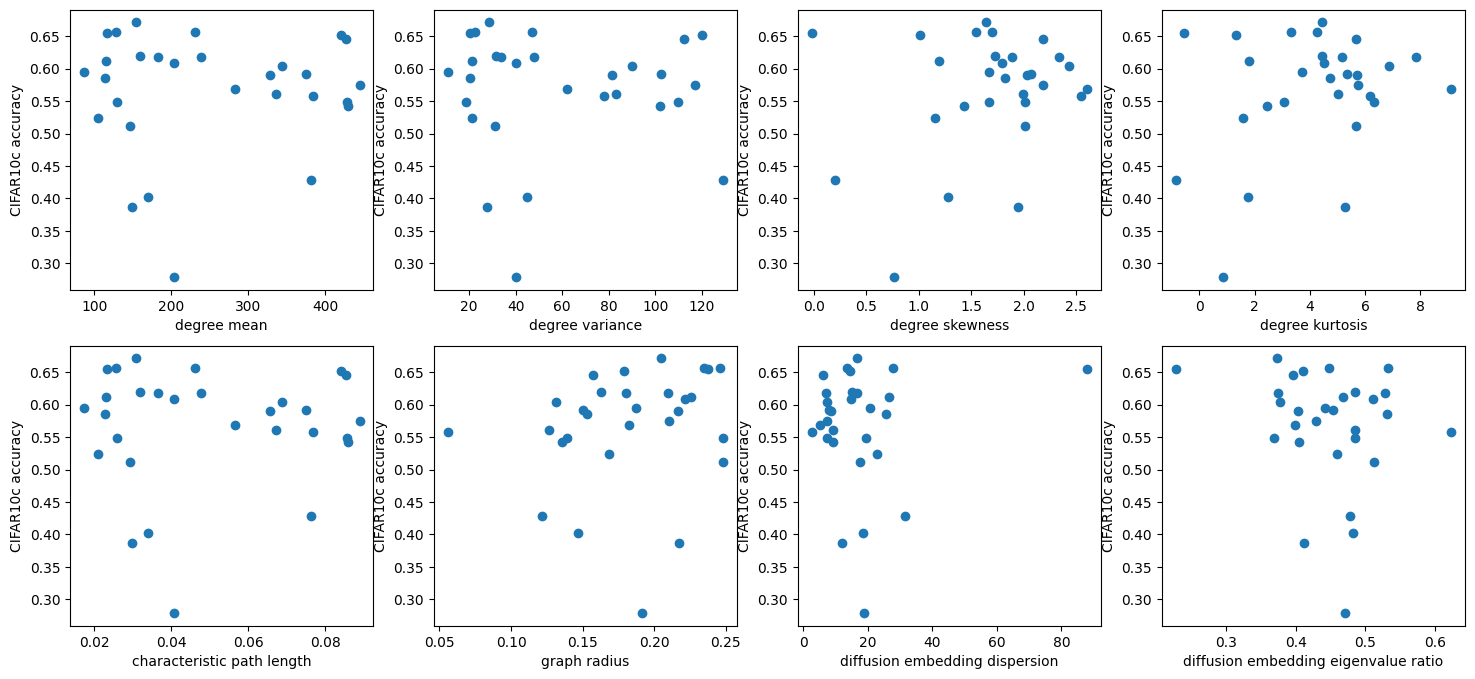

In [70]:
fig, axs = plt.subplots(2,4,figsize=(18, 8))

for i in range (4):
    axs[0,i].scatter(cifar_graph_metrics_ar[:,i],cifar_ood_accs_corrupted)
    axs[0,i].set_xlabel(graph_metrics_names[i])
    axs[0,i].set_ylabel('CIFAR10c accuracy')

for i in range (4):
    axs[1,i].scatter(cifar_graph_metrics_ar[:,4+i],cifar_ood_accs_corrupted)
    axs[1,i].set_xlabel(graph_metrics_names[4+i])
    axs[1,i].set_ylabel('CIFAR10c accuracy')


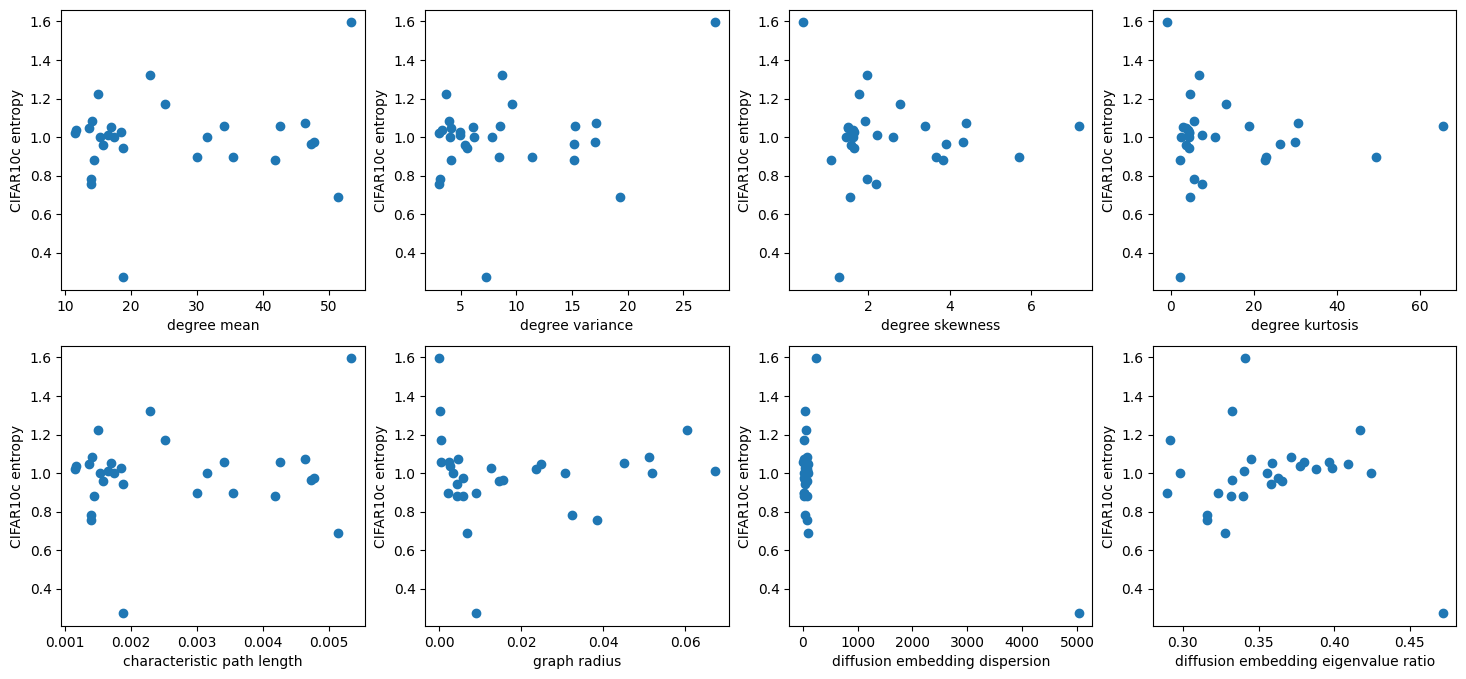

In [17]:
fig, axs = plt.subplots(2,4,figsize=(18, 8))

for i in range (4):
    axs[0,i].scatter(cifar_graph_metrics_ar[:,i],cifar_ood_ent_corrupted)
    axs[0,i].set_xlabel(graph_metrics_names[i])
    axs[0,i].set_ylabel('CIFAR10c entropy')

for i in range (4):
    axs[1,i].scatter(cifar_graph_metrics_ar[:,4+i],cifar_ood_ent_corrupted)
    axs[1,i].set_xlabel(graph_metrics_names[4+i])
    axs[1,i].set_ylabel('CIFAR10c entropy')

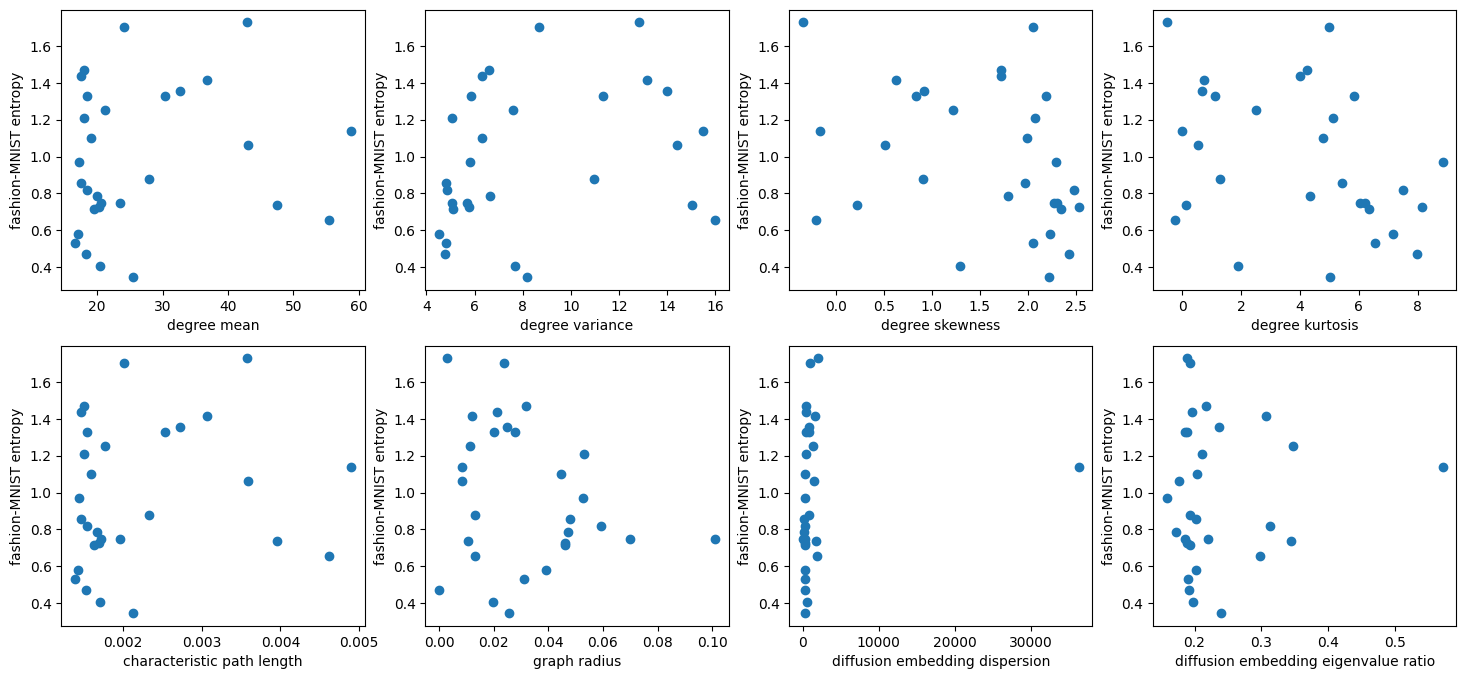

In [18]:
fig, axs = plt.subplots(2,4,figsize=(18, 8))

for i in range (4):
    axs[0,i].scatter(mnist_graph_metrics_ar[:,i],mnist_ood_ent_fashion)
    axs[0,i].set_xlabel(graph_metrics_names[i])
    axs[0,i].set_ylabel('fashion-MNIST entropy')

for i in range (4):
    axs[1,i].scatter(mnist_graph_metrics_ar[:,4+i],mnist_ood_ent_fashion)
    axs[1,i].set_xlabel(graph_metrics_names[4+i])
    axs[1,i].set_ylabel('fashion-MNIST entropy')

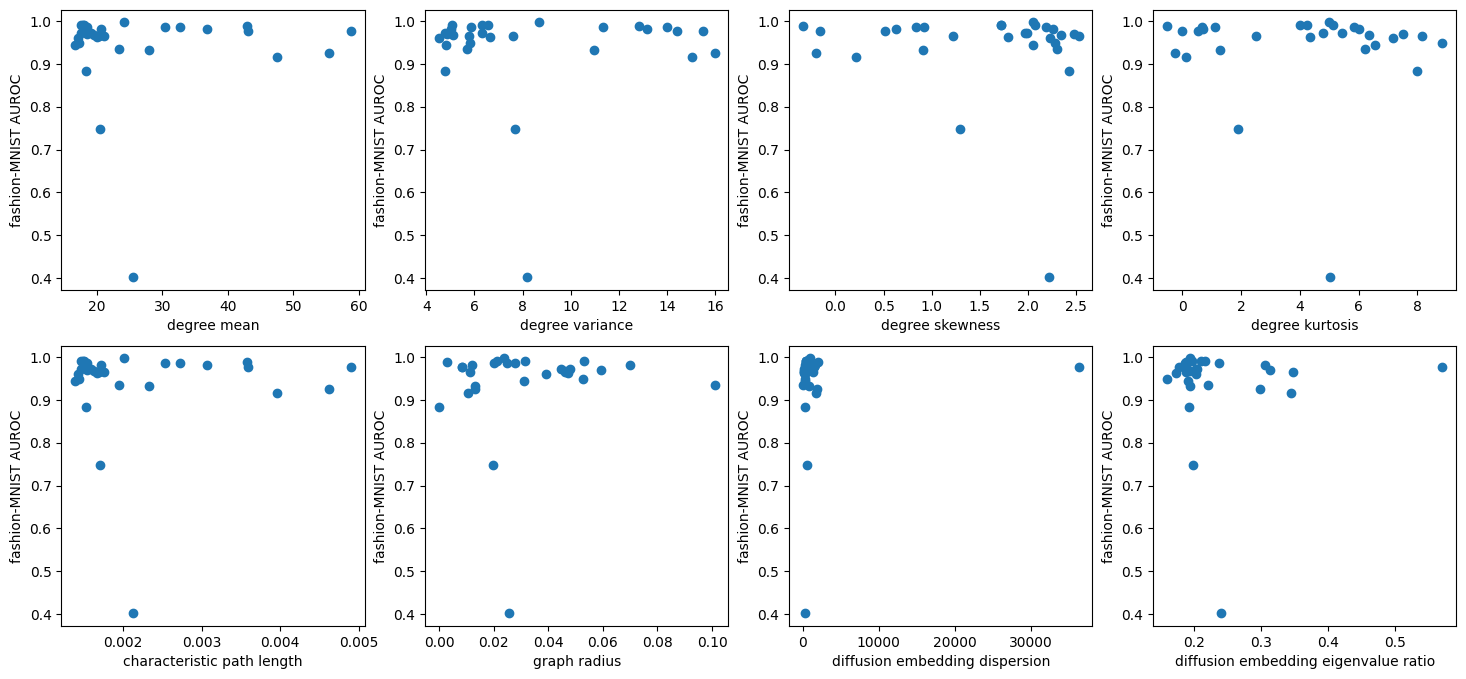

In [19]:
fig, axs = plt.subplots(2,4,figsize=(18, 8))

for i in range (4):
    axs[0,i].scatter(mnist_graph_metrics_ar[:,i],mnist_auroc_scores)
    axs[0,i].set_xlabel(graph_metrics_names[i])
    axs[0,i].set_ylabel('fashion-MNIST AUROC')

for i in range (4):
    axs[1,i].scatter(mnist_graph_metrics_ar[:,4+i],mnist_auroc_scores)
    axs[1,i].set_xlabel(graph_metrics_names[4+i])
    axs[1,i].set_ylabel('fashion-MNIST AUROC')

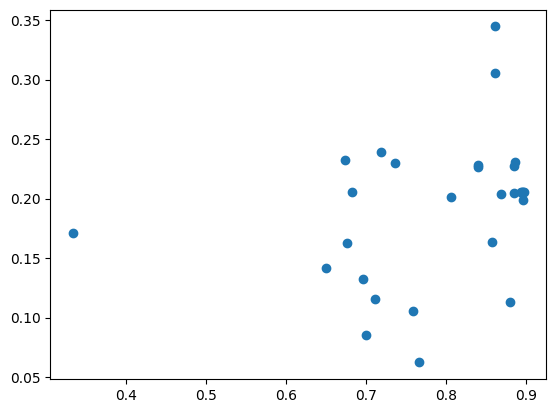

In [72]:
plt.figure()
plt.scatter(mnist_graph_metrics_ar[:,8],mnist_ood_accuracy)

In [ ]:
plt.figure()

plt.scatter(cifar_graph_metrics_ar[:,0],cifar_ood_accuracy)
plt.xlabel('mean degree')
plt.ylabel('CIFAR10c accuracy')
plt.show()

plt.figure()

plt.scatter(cifar_graph_metrics_ar[:,1],cifar_ood_accuracy)
plt.xlabel('degree variance')
plt.ylabel('CIFAR10c accuracy')
plt.show()

plt.figure()

plt.scatter(cifar_graph_metrics_ar[:,-1],cifar_ood_accuracy)
plt.xlabel('degree skewness')
plt.ylabel('CIFAR10c accuracy')
plt.show()

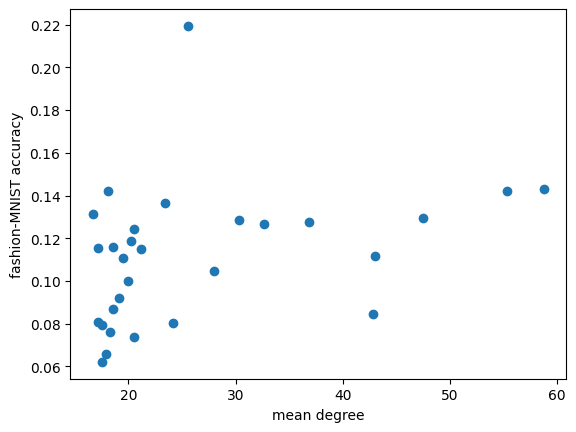

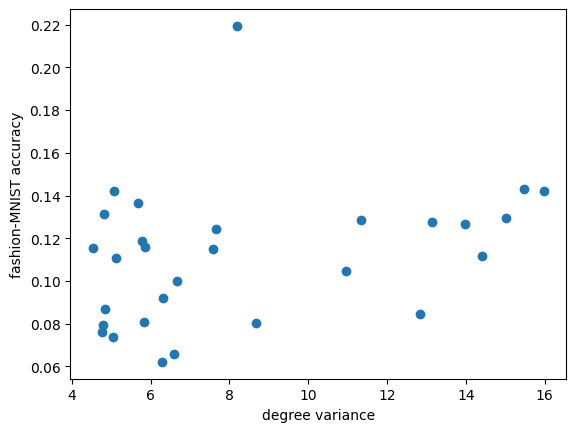

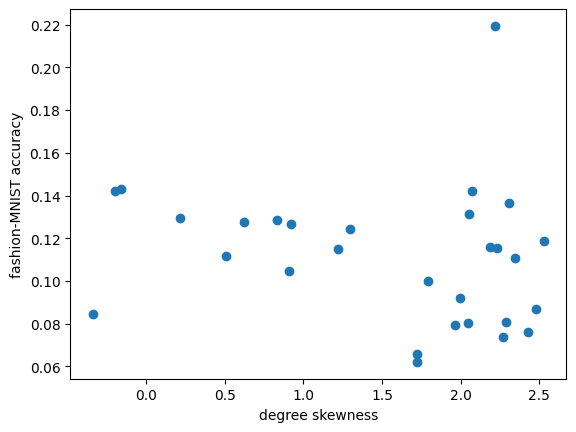

In [22]:
plt.figure()

plt.scatter(mnist_graph_metrics_ar[:,0],mnist_ood_accuracy)
plt.xlabel('mean degree')
plt.ylabel('fashion-MNIST accuracy')
plt.show()

plt.figure()

plt.scatter(mnist_graph_metrics_ar[:,1],mnist_ood_accuracy)
plt.xlabel('degree variance')
plt.ylabel('fashion-MNIST accuracy')
plt.show()

plt.figure()

plt.scatter(mnist_graph_metrics_ar[:,2],mnist_ood_accuracy)
plt.xlabel('degree skewness')
plt.ylabel('fashion-MNIST accuracy')
plt.show()

In [67]:
model_names[20]

'extreme_resnet'

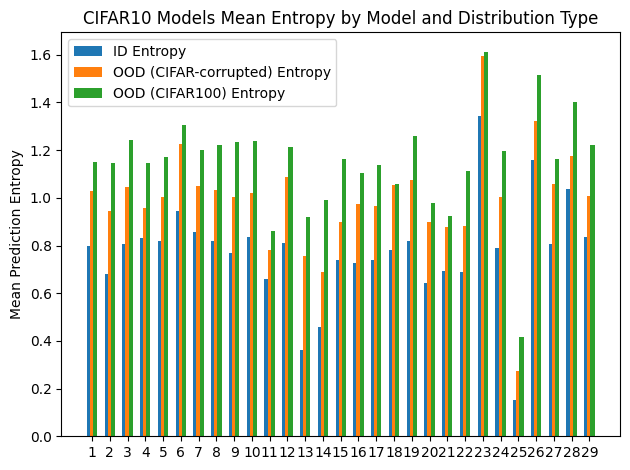

In [73]:
import matplotlib.pyplot as plt
import numpy as np


ID_entropies = cifar_id_entropy
OOD_entropies = cifar_ood_ent_corrupted
OOD_entropies2 = cifar100_ood_ent
x = np.arange(len(model_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ID_entropies, width/1.5, label='ID Entropy')
rects2 = ax.bar(x , OOD_entropies, width/1.5, label='OOD (CIFAR-corrupted) Entropy')
rects2 = ax.bar(x + width/2, OOD_entropies2, width/1.5, label='OOD (CIFAR100) Entropy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Prediction Entropy')
ax.set_title('CIFAR10 Models Mean Entropy by Model and Distribution Type')
ax.set_xticks(x)

# Set x-axis labels to be numbers from 1 to the length of model_names
ax.set_xticklabels(range(1, len(model_names) + 1))

ax.legend()

fig.tight_layout()
plt.show()


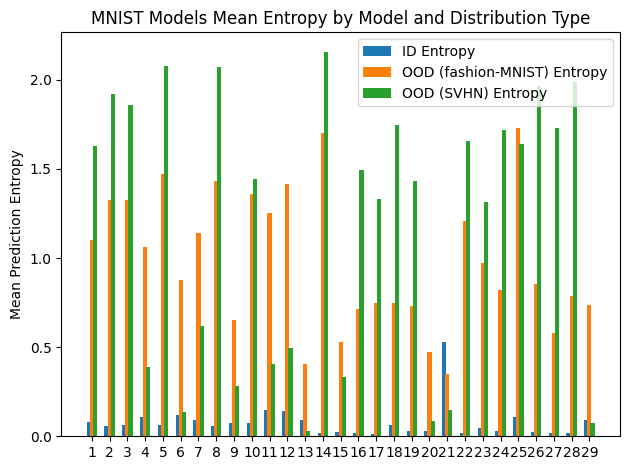

In [74]:

ID_entropies = mnist_id_entropy
OOD_entropies = mnist_ood_entropy
OOD_entropies2 = mnist_ood_entropy_svhn
x = np.arange(len(model_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, ID_entropies, width/1.5, label='ID Entropy')
rects2 = ax.bar(x , OOD_entropies, width/1.5, label='OOD (fashion-MNIST) Entropy')
rects2 = ax.bar(x + width/2, OOD_entropies2, width/1.5, label='OOD (SVHN) Entropy')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Prediction Entropy')
ax.set_title('MNIST Models Mean Entropy by Model and Distribution Type')
ax.set_xticks(x)

# Set x-axis labels to be numbers from 1 to the length of model_names
ax.set_xticklabels(range(1, len(model_names) + 1))

ax.legend()

fig.tight_layout()
plt.show()


In [76]:
print(mnist_graph_metrics_ar.shape)

(29, 9)


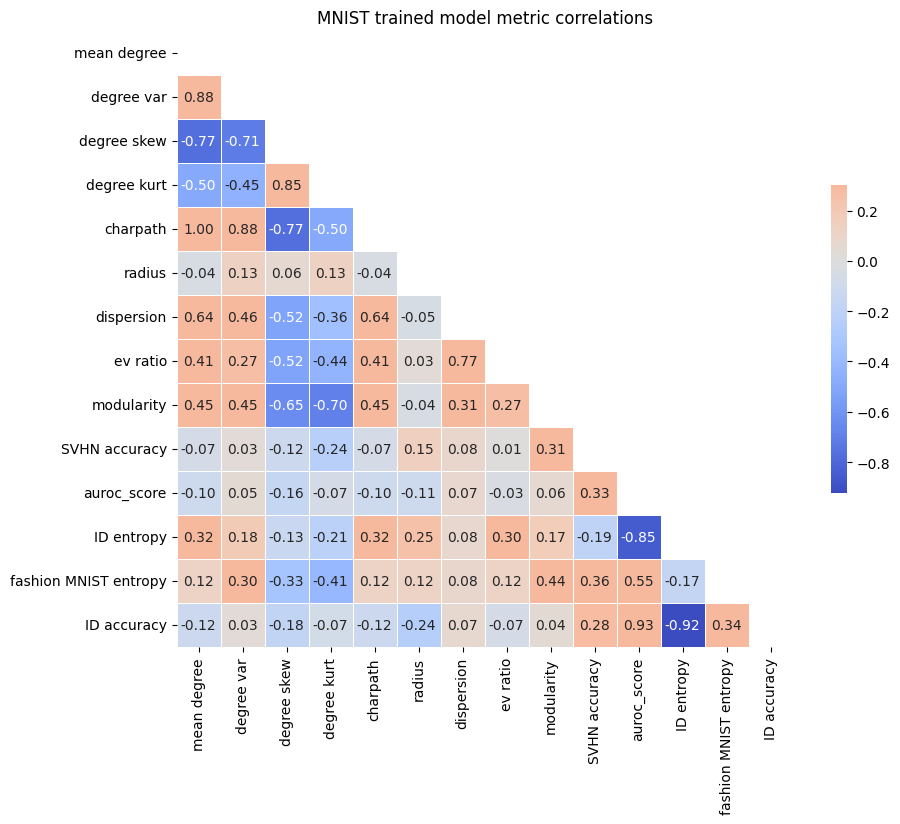

In [77]:
import pandas as pd
import seaborn as sns

data = {
    'mean degree': mnist_graph_metrics_ar[:,0],
    'degree var' : mnist_graph_metrics_ar[:,1],
    'degree skew': mnist_graph_metrics_ar[:,2],
    'degree kurt' : mnist_graph_metrics_ar[:,3],
    'charpath' : mnist_graph_metrics_ar[:,4],
    'radius' : mnist_graph_metrics_ar[:,5],
    'dispersion' : mnist_graph_metrics_ar[:,6],
    'ev ratio' : mnist_graph_metrics_ar[:,7],
    'modularity' : mnist_graph_metrics_ar[:,8],
    'SVHN accuracy' : mnist_ood_accuracy,
    'auroc_score' : mnist_auroc_scores,
    'ID entropy': mnist_id_entropy,
    'fashion MNIST entropy': mnist_ood_entropy,
    'ID accuracy' : mnist_id_test_accuracy
}

df = pd.DataFrame(data)

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('MNIST trained model metric correlations')
plt.show()



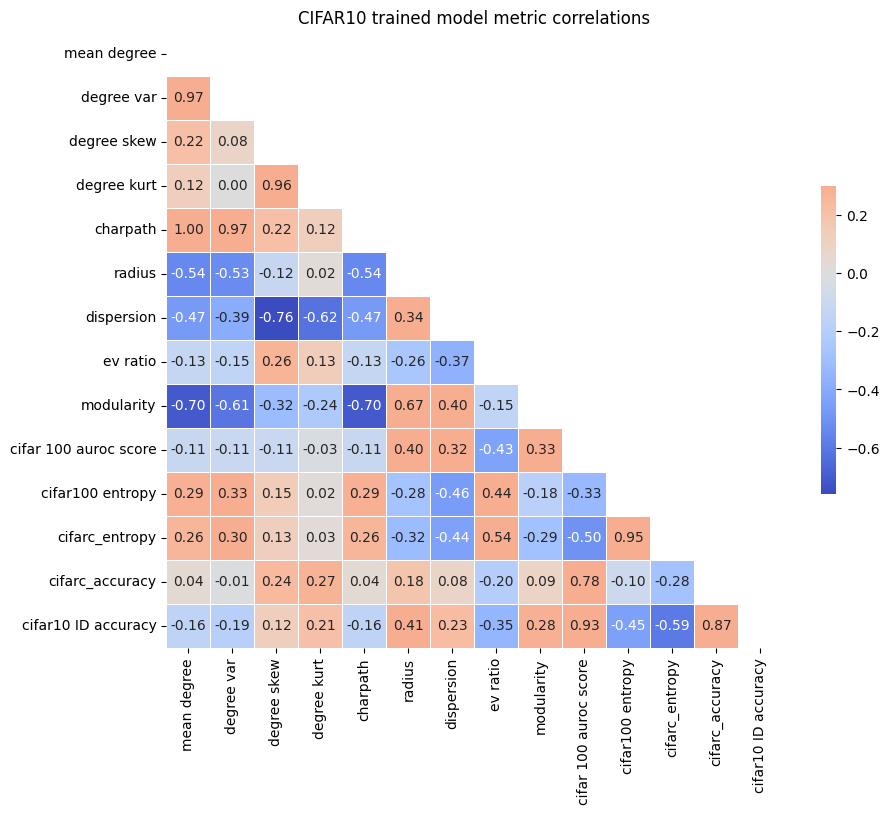

In [78]:
import pandas as pd
import seaborn as sns
data = {
    'mean degree': cifar_graph_metrics_ar[:,0],
    'degree var' : cifar_graph_metrics_ar[:,1],
    'degree skew': cifar_graph_metrics_ar[:,2],
    'degree kurt' : cifar_graph_metrics_ar[:,3],
    'charpath' : cifar_graph_metrics_ar[:,4],
    'radius' : cifar_graph_metrics_ar[:,5],
    'dispersion' : cifar_graph_metrics_ar[:,6],
    'ev ratio' : cifar_graph_metrics_ar[:,7],
    'modularity' : mnist_graph_metrics_ar[:,8],
    'cifar 100 auroc score' : cifar_auroc_scores,
    'cifar100 entropy' : cifar100_entropy,
    'cifarc_entropy': cifarc_entropy,
    'cifarc_accuracy': cifar_ood_accuracy,
    'cifar10 ID accuracy': cifar_id_test_accuracy
}

df = pd.DataFrame(data)

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('CIFAR10 trained model metric correlations')
plt.show()

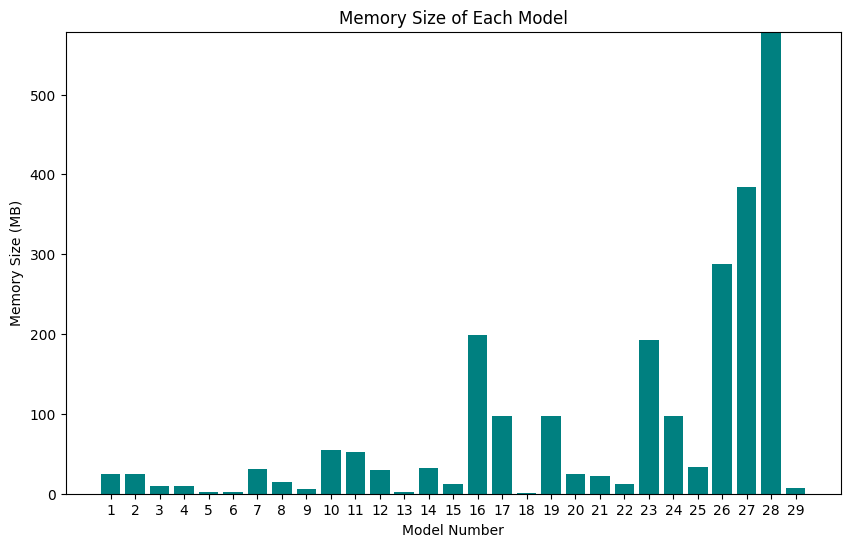

In [ ]:
import os

# Directory where your models are saved
model_directory = '/content/drive/My Drive/ood_generalization_proj/cnn_models'


# Get the size of each model in megabytes
model_sizes = [os.path.getsize(os.path.join(model_directory, model_name+'.keras')) / (1024 * 1024) for model_name in model_names]

plt.figure(figsize=(10, 6))
# Create bar plot
plt.bar(range(1, len(model_names) + 1), model_sizes, color='teal')  # use range for x-axis values

plt.xlabel('Model Number')
plt.ylabel('Memory Size (MB)')
plt.title('Memory Size of Each Model')
plt.xticks(range(1, len(model_names) + 1))  # set x-axis ticks to be sequential numbers
plt.ylim(0, max(model_sizes) + 1)  # Add some space above the tallest bar for better visualization
plt.show()


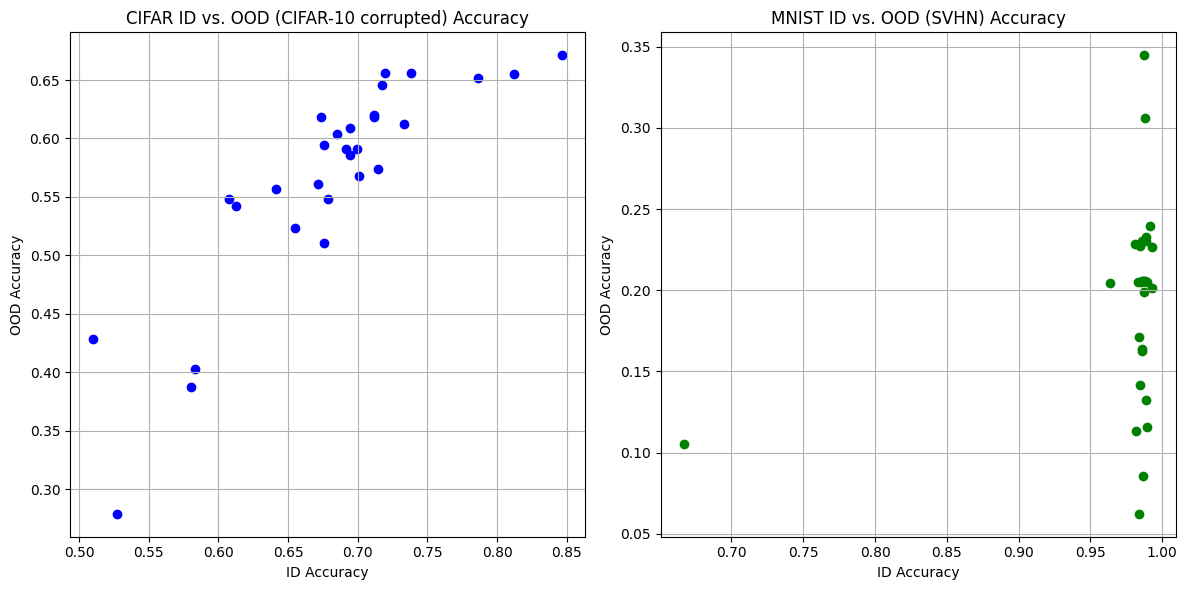

In [79]:
import matplotlib.pyplot as plt

# Assuming cifar_id_test_accuracy and mnist_id_test_accuracy contain in-distribution accuracies
# and cifar_ood_accuracy and mnist_ood_accuracy contain out-of-distribution accuracies
plt.figure(figsize=(12, 6))

# CIFAR
plt.subplot(1, 2, 1)
plt.scatter(cifar_id_test_accuracy, cifar_ood_accs_corrupted, color='blue')
plt.title('CIFAR ID vs. OOD (CIFAR-10 corrupted) Accuracy')
plt.xlabel('ID Accuracy')
plt.ylabel('OOD Accuracy')
plt.grid(True)

# MNIST
plt.subplot(1, 2, 2)
plt.scatter(mnist_id_test_accuracy, mnist_ood_accuracy, color='green')
plt.title('MNIST ID vs. OOD (SVHN) Accuracy')
plt.xlabel('ID Accuracy')
plt.ylabel('OOD Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


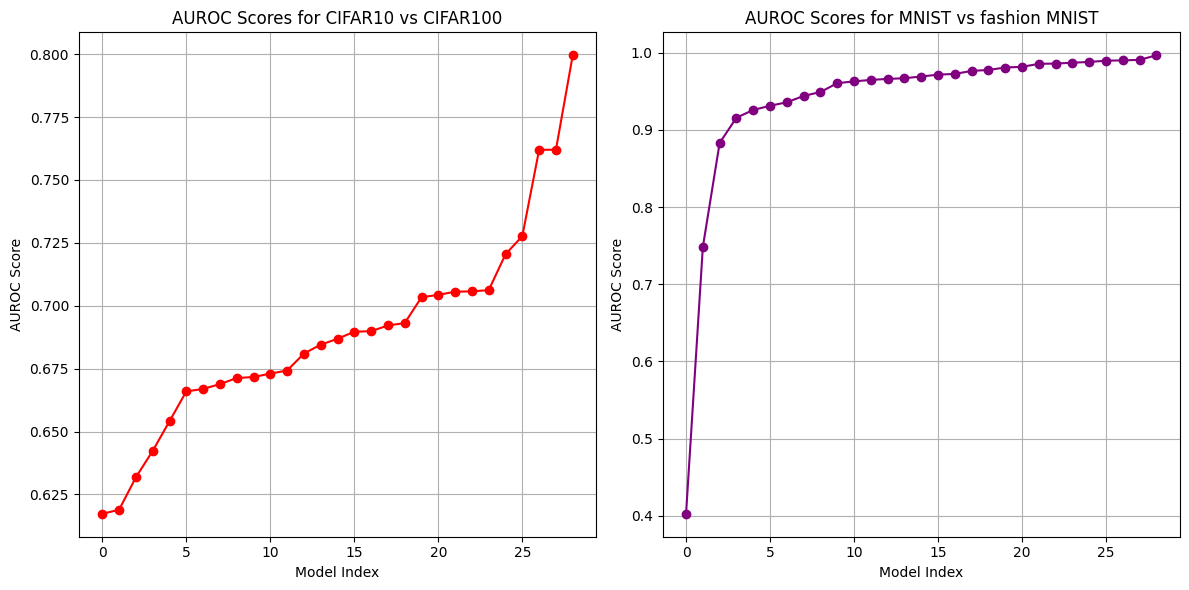

In [80]:
import numpy as np

# Load or set cifar_auroc_scores and mnist_auroc_scores arrays
# Sort the AUROC scores
sorted_cifar_auroc = np.sort(cifar_auroc_scores)
sorted_mnist_auroc = np.sort(mnist_auroc_scores)

plt.figure(figsize=(12, 6))

# CIFAR
plt.subplot(1, 2, 1)
plt.plot(sorted_cifar_auroc, marker='o', linestyle='-', color='red')
plt.title('AUROC Scores for CIFAR10 vs CIFAR100')
plt.xlabel('Model Index')
plt.ylabel('AUROC Score')
plt.grid(True)

# MNIST
plt.subplot(1, 2, 2)
plt.plot(sorted_mnist_auroc, marker='o', linestyle='-', color='purple')
plt.title('AUROC Scores for MNIST vs fashion MNIST')
plt.xlabel('Model Index')
plt.ylabel('AUROC Score')
plt.grid(True)

plt.tight_layout()
plt.show()


Combined R² Score (ID Accuracy): 0.7957723935125564
Combined Intercept (ID Accuracy): 0.9382658621331846
degree mean ID acc coefficient: 0.003475533932784594
degree variance ID acc coefficient: 0.0027332483484018514
degree skewness ID acc coefficient: -0.0025162344594386165
degree kurtosis ID acc coefficient: 0.011173244117654798
characteristic path length ID acc coefficient: -22.46464687661254
graph radius ID acc coefficient: -0.05477045384496688
diffusion embedding dispersion ID acc coefficient: 3.6119066658747455e-05
diffusion embedding eigenvalue ratio ID acc coefficient: -0.5734923044579052
modularity ID acc coefficient: 0.13691179292233674


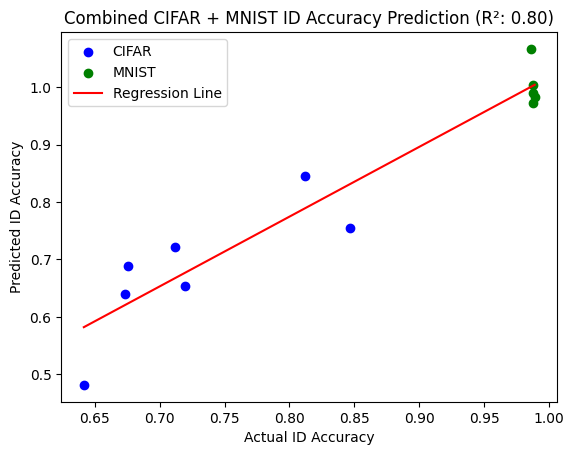

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Add a label to distinguish between CIFAR and MNIST data
cifar_labels = np.full(len(cifar_graph_metrics_ar), 'CIFAR')
mnist_labels = np.full(len(mnist_graph_metrics_ar), 'MNIST')

# Combine the graph metrics and labels
combined_graph_metrics = np.vstack([cifar_graph_metrics_ar, mnist_graph_metrics_ar])
combined_labels = np.concatenate([cifar_labels, mnist_labels])
combined_id_accuracies = np.concatenate([cifar_id_test_accuracy, mnist_id_test_accuracy])

# Split the data into training and testing sets
graph_train, graph_test, id_train, id_test, label_train, label_test = train_test_split(
    combined_graph_metrics, combined_id_accuracies, combined_labels, test_size=0.2, random_state=20
)

# Initialize and fit a single linear regression model on the combined data
combined_model = LinearRegression()
combined_model.fit(graph_train, id_train)

# Predict ID accuracy on the test set
id_predicted = combined_model.predict(graph_test)

# Calculate the R² score for the predictions
combined_r2 = r2_score(id_test, id_predicted)

# Display model coefficients and intercept
print("Combined R² Score (ID Accuracy):", combined_r2)
print("Combined Intercept (ID Accuracy):", combined_model.intercept_)
for name, coef in zip(graph_metrics_names, combined_model.coef_):
    print(f"{name} ID acc coefficient: {coef}")

# Create a scatter plot with different colors for CIFAR and MNIST models
plt.figure()
for label, color in [('CIFAR', 'blue'), ('MNIST', 'green')]:
    idx = np.where(label_test == label)
    plt.scatter(id_test[idx], id_predicted[idx], color=color, label=label)

plt.xlabel('Actual ID Accuracy')
plt.ylabel('Predicted ID Accuracy')
plt.title(f'Combined CIFAR + MNIST ID Accuracy Prediction (R²: {combined_r2:.2f})')
plt.legend()

# Calculate and plot the regression line (y = mx + c)
x_range = np.linspace(min(id_test), max(id_test), 100)
m, c = np.polyfit(id_test, id_predicted, 1)
regression_line = m * x_range + c
plt.plot(x_range, regression_line, color='red', label='Regression Line')
plt.legend()
plt.show()

MNIST Coefficients: [-7.70768032e-03  3.26418882e-02  2.37897012e-02 -5.14748231e-02
 -1.28482752e-06  2.90019589e-01  5.42125027e-05 -1.18759975e-01
  8.15414734e-01]
MNIST Intercept: 0.5119896091878339
CIFAR10 Coefficients: [-5.41869285e-04  5.44404976e-03  6.03678125e-02  1.54448150e-03
 -1.08395535e-07 -1.04037070e-01 -1.23978331e-02  1.47243007e+00
  1.78562243e+00]
CIFAR10 Intercept: -0.2997548348480237
CIFAR10 Actual OOD entropy: 1.1487376689910889, Predicted OOD entropy: 0.37148289656499595
CIFAR10 Actual OOD entropy: 1.146270751953125, Predicted OOD entropy: 0.4429902714878806
CIFAR10 Actual OOD entropy: 1.2427538633346558, Predicted OOD entropy: 0.5517546747634235
CIFAR10 Actual OOD entropy: 1.1475858688354492, Predicted OOD entropy: 0.9610286174981334
CIFAR10 Actual OOD entropy: 1.1704550981521606, Predicted OOD entropy: 0.3008327976495494
CIFAR10 Actual OOD entropy: 1.3071626424789429, Predicted OOD entropy: 0.5420412614527815
CIFAR10 Actual OOD entropy: 1.2012094259262085,

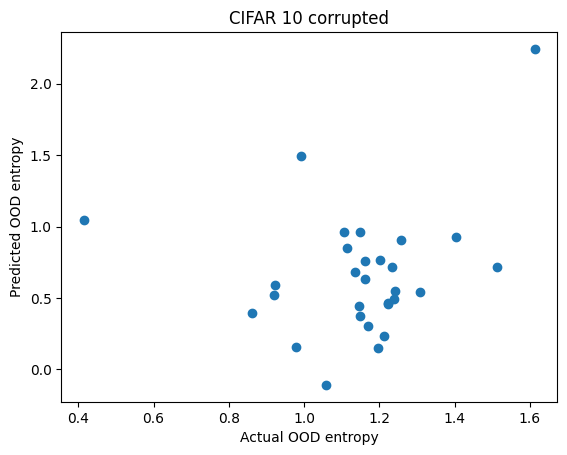

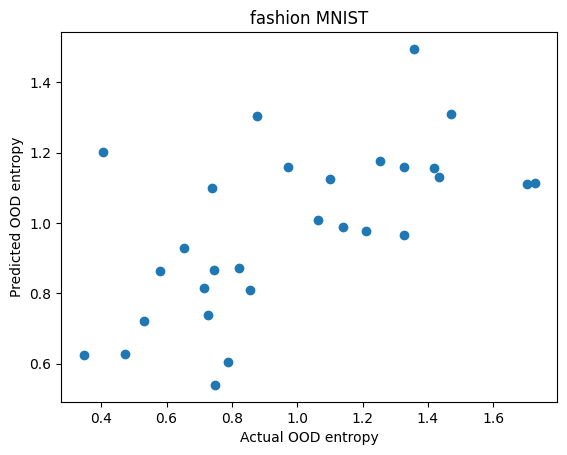

In [99]:
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
mnist_model = LinearRegression()
cifar_model = LinearRegression()

# Fit the model
mnist_model.fit(mnist_graph_metrics_ar, mnist_ood_entropy)
cifar_model.fit(cifar_graph_metrics_ar, cifar100_entropy)
# Get the coefficients (weights) of the linear regression model
mnist_coefficients = mnist_model.coef_
cifar_coefficients = cifar_model.coef_
# Get the intercept of the model
mnist_intercept = mnist_model.intercept_
cifar_intercept = cifar_model.intercept_

print("MNIST Coefficients:", mnist_coefficients)
print("MNIST Intercept:", mnist_intercept)

print("CIFAR10 Coefficients:", cifar_coefficients)
print("CIFAR10 Intercept:", cifar_intercept)

mnist_predicted_ood_auroc = mnist_model.predict(mnist_graph_metrics_ar)
cifar_predicted_ood_auroc = mnist_model.predict(cifar_graph_metrics_ar)


# Compare predictions with actual OOD accuracies
for actual, predicted in zip(cifar100_entropy, cifar_predicted_ood_auroc):
    print(f"CIFAR10 Actual OOD entropy: {actual}, Predicted OOD entropy: {predicted}")
for actual, predicted in zip(mnist_ood_entropy, mnist_predicted_ood_auroc):
    print(f"MNIST Actual OOD entropy: {actual}, Predicted entropy: {predicted}")

cifar_r2 = r2_score(cifar100_entropy, cifar_predicted_ood_auroc)
print("CIFAR 10 R² Score:", cifar_r2)

mnist_r2 = r2_score(mnist_ood_entropy, mnist_predicted_ood_auroc)
print("MNIST R² Score:", mnist_r2)


plt.figure()
plt.scatter(cifar100_entropy,cifar_predicted_ood_auroc)
plt.xlabel('Actual OOD entropy')
plt.ylabel('Predicted OOD entropy')
plt.title('CIFAR 10 corrupted')
plt.show()

plt.figure()
plt.scatter(mnist_ood_entropy,mnist_predicted_ood_auroc)
plt.xlabel('Actual OOD entropy')
plt.ylabel('Predicted OOD entropy')
plt.title('fashion MNIST')
plt.show()


In [54]:
X_train.shape

(50000, 32, 32, 3)

Combined R² Score: 0.7852931824767473
Combined Coefficients: [-1.84656362 -0.12441358 -0.03539509  0.06449935  2.14490501  0.02019278
  0.00477476  0.050882    0.13023379]
Combined Intercept: 0.39314749883487915


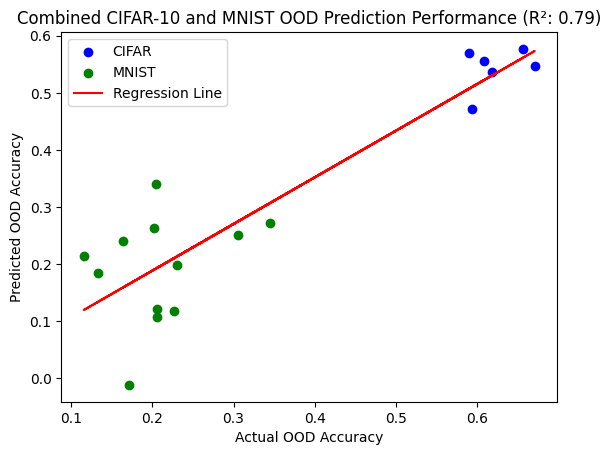

In [94]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Create labels to differentiate CIFAR and MNIST datasets
cifar_labels = np.full(len(cifar_graph_metrics), 'CIFAR')
mnist_labels = np.full(len(mnist_graph_metrics), 'MNIST')

# Combine graph metrics, labels, and OOD accuracies
combined_graph_metrics = np.vstack([cifar_graph_metrics, mnist_graph_metrics])
combined_labels = np.concatenate([cifar_labels, mnist_labels])
combined_ood_accuracies = np.concatenate([cifar_ood_accuracy, mnist_ood_accuracy])

# Split the combined data into training and testing sets
X_train, X_test, y_train, y_test, label_train, label_test = train_test_split(
    combined_graph_metrics, combined_ood_accuracies, combined_labels, test_size=0.3, random_state=8
)

# Normalize features using a single scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train a unified linear regression model
combined_model = LinearRegression()
combined_model.fit(X_train_scaled, y_train)

# Predictions using the unified model
y_pred = combined_model.predict(X_test_scaled)

# Calculate R² score for the predictions
combined_r2 = r2_score(y_test, y_pred)

# Print results
print("Combined R² Score:", combined_r2)
print("Combined Coefficients:", combined_model.coef_)
print("Combined Intercept:", combined_model.intercept_)

# Visualization of actual vs. predicted OOD accuracies, color-coded by dataset
plt.figure()
for label, color in [('CIFAR', 'blue'), ('MNIST', 'green')]:
    idx = np.where(label_test == label)
    plt.scatter(y_test[idx], y_pred[idx], color=color, label=label)

plt.xlabel('Actual OOD Accuracy')
plt.ylabel('Predicted OOD Accuracy')
plt.title(f'Combined CIFAR-10 and MNIST OOD Prediction Performance (R²: {combined_r2:.2f})')
plt.legend()

# Calculate the regression line
coeffs = np.polyfit(y_test, y_pred, 1)
fit_line = np.polyval(coeffs, y_test)

# Plot the regression line
plt.plot(y_test, fit_line, color='red', label='Regression Line')
plt.legend()
plt.show()


Combined R² Score: 0.32190496813281166
Combined Coefficients: [ 0.11605246  0.34656356  0.04351822  0.00052391 -0.40399081  0.0202814
 -0.05938411  0.22505931  0.12171294]
Combined Intercept: 1.0496927052736278


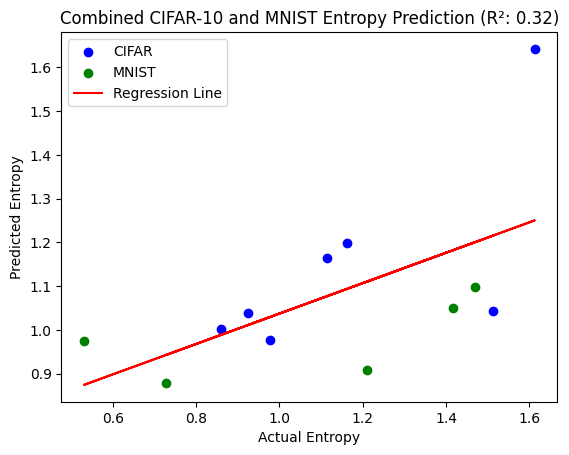

In [108]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Labels to distinguish between CIFAR and MNIST datasets
cifar_labels = np.full(len(cifar_graph_metrics), 'CIFAR')
mnist_labels = np.full(len(mnist_graph_metrics), 'MNIST')

# Combine graph metrics, labels, and new target entropy values
combined_graph_metrics = np.vstack([cifar_graph_metrics, mnist_graph_metrics])
combined_labels = np.concatenate([cifar_labels, mnist_labels])
combined_entropies = np.concatenate([cifar100_entropy, mnist_ood_entropy])

# Split the combined data into training and testing sets
X_train, X_test, y_train, y_test, label_train, label_test = train_test_split(
    combined_graph_metrics, combined_entropies, combined_labels, test_size=0.2, random_state=30
)

# Normalize features using a single scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train a unified linear regression model
combined_model = LinearRegression()
combined_model.fit(X_train_scaled, y_train)

# Predictions using the unified model
y_pred = combined_model.predict(X_test_scaled)

# Calculate R² score for the predictions
combined_r2 = r2_score(y_test, y_pred)

# Print results
print("Combined R² Score:", combined_r2)
print("Combined Coefficients:", combined_model.coef_)
print("Combined Intercept:", combined_model.intercept_)

# Visualization of actual vs. predicted entropy values
plt.figure()
for label, color in [('CIFAR', 'blue'), ('MNIST', 'green')]:
    idx = np.where(label_test == label)
    plt.scatter(y_test[idx], y_pred[idx], color=color, label=label)

plt.xlabel('Actual Entropy')
plt.ylabel('Predicted Entropy')
plt.title(f'Combined CIFAR-10 and MNIST Entropy Prediction (R²: {combined_r2:.2f})')
plt.legend()

# Calculate the regression line
coeffs = np.polyfit(y_test, y_pred, 1)
fit_line = np.polyval(coeffs, y_test)

# Plot the regression line
plt.plot(y_test, fit_line, color='red', label='Regression Line')
plt.legend()
plt.show()


In [98]:
np.mean(cifar_id_test_accuracy)

0.6810137937808859

MNIST R² Score: -1.7246458650339784
CIFAR 10 R² Score: -1.232838286752207


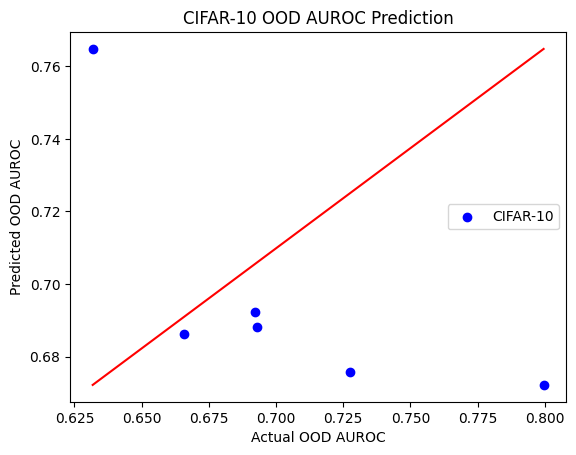

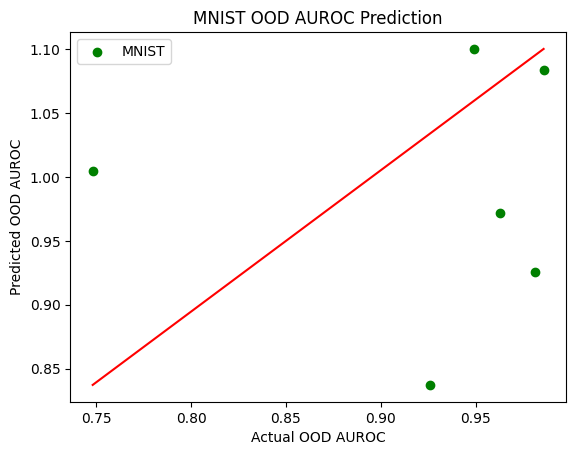

In [100]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mnist_ood_auroc = mnist_auroc_scores
cifar_ood_auroc = cifar_auroc_scores
# Normalizing features
scaler = StandardScaler()

# Split data for both datasets
mnist_X_train, mnist_X_test, mnist_y_train, mnist_y_test = train_test_split(
    mnist_graph_metrics, mnist_ood_auroc, test_size=0.2, random_state=42)
cifar_X_train, cifar_X_test, cifar_y_train, cifar_y_test = train_test_split(
    cifar_graph_metrics, cifar_ood_auroc, test_size=0.2, random_state=42)

# Scale the features
mnist_X_train_scaled = scaler.fit_transform(mnist_X_train)
mnist_X_test_scaled = scaler.transform(mnist_X_test)
cifar_X_train_scaled = scaler.fit_transform(cifar_X_train)
cifar_X_test_scaled = scaler.transform(cifar_X_test)

# Initialize the model, using Ridge regression to add regularization
mnist_model = Ridge(alpha=1.0)
cifar_model = Ridge(alpha=1.0)

# Fit the models
#mnist_model.fit(mnist_X_train_scaled, mnist_y_train)
#cifar_model.fit(cifar_X_train_scaled, cifar_y_train)

# Predictions
#mnist_predicted_ood_auroc = mnist_model.predict(mnist_X_test_scaled)
#cifar_predicted_ood_auroc = cifar_model.predict(cifar_X_test_scaled)

mnist_model.fit(mnist_X_train, mnist_y_train)
cifar_model.fit(cifar_X_train, cifar_y_train)

# Predictions
mnist_predicted_ood_auroc = mnist_model.predict(mnist_X_test)
cifar_predicted_ood_auroc = cifar_model.predict(cifar_X_test)


# Evaluate with R² Score
print("MNIST R² Score:", r2_score(mnist_y_test, mnist_predicted_ood_auroc))
print("CIFAR 10 R² Score:", r2_score(cifar_y_test, cifar_predicted_ood_auroc))

# Visualization of results
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(cifar_y_test, cifar_predicted_ood_auroc, color='blue', label='CIFAR-10')
plt.plot([min(cifar_y_test), max(cifar_y_test)], [min(cifar_predicted_ood_auroc), max(cifar_predicted_ood_auroc)], color='red')
plt.xlabel('Actual OOD AUROC')
plt.ylabel('Predicted OOD AUROC')
plt.title('CIFAR-10 OOD AUROC Prediction')
plt.legend()
plt.show()

plt.figure()
plt.scatter(mnist_y_test, mnist_predicted_ood_auroc, color='green', label='MNIST')
plt.plot([min(mnist_y_test), max(mnist_y_test)], [min(mnist_predicted_ood_auroc), max(mnist_predicted_ood_auroc)], color='red')
plt.xlabel('Actual OOD AUROC')
plt.ylabel('Predicted OOD AUROC')
plt.title('MNIST OOD AUROC Prediction')
plt.legend()
plt.show()


MNIST R² Score: -1.8402546445618668
CIFAR 10 R² Score: -0.8088091856098358


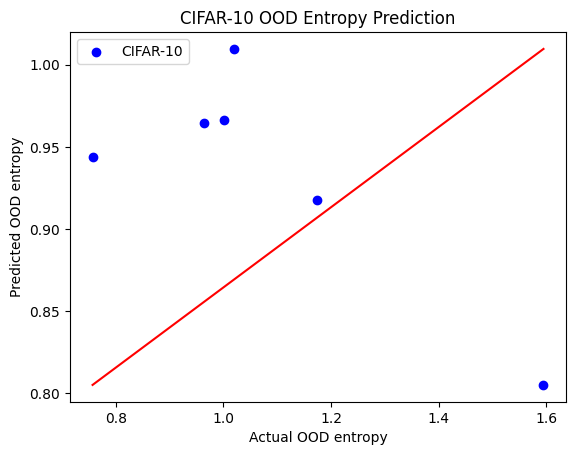

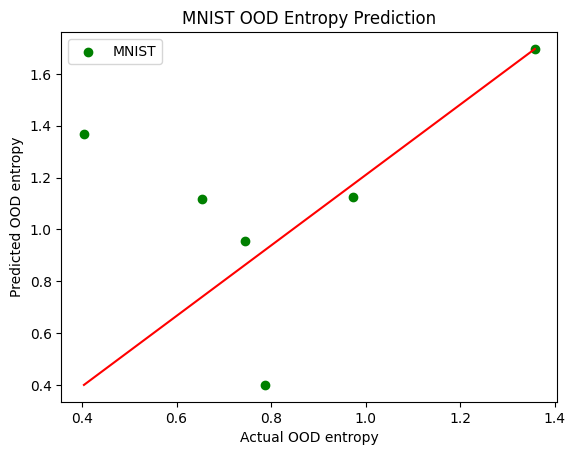

In [101]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mnist_ood_ent = mnist_ood_ent_fashion
cifar_ood_ent = cifar_ood_ent_corrupted
# Data preparation
scaler = StandardScaler()

# Split data
mnist_X_train, mnist_X_test, mnist_y_train, mnist_y_test = train_test_split(
    mnist_graph_metrics, mnist_ood_ent, test_size=0.2, random_state=42)
cifar_X_train, cifar_X_test, cifar_y_train, cifar_y_test = train_test_split(
    cifar_graph_metrics, cifar_ood_ent, test_size=0.2, random_state=42)

# Normalize features
mnist_X_train_scaled = scaler.fit_transform(mnist_X_train)
mnist_X_test_scaled = scaler.transform(mnist_X_test)
cifar_X_train_scaled = scaler.fit_transform(cifar_X_train)
cifar_X_test_scaled = scaler.transform(cifar_X_test)

# Initialize Ridge regression models
mnist_model = Ridge(alpha=1.0)
cifar_model = Ridge(alpha=1.0)

# Fit models
mnist_model.fit(mnist_X_train_scaled, mnist_y_train)
cifar_model.fit(cifar_X_train_scaled, cifar_y_train)

# Predictions
mnist_predicted_ood_ent = mnist_model.predict(mnist_X_test_scaled)
cifar_predicted_ood_ent = cifar_model.predict(cifar_X_test_scaled)

# Print R² scores
print("MNIST R² Score:", r2_score(mnist_y_test, mnist_predicted_ood_ent))
print("CIFAR 10 R² Score:", r2_score(cifar_y_test, cifar_predicted_ood_ent))

# Visualization
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(cifar_y_test, cifar_predicted_ood_ent, color='blue', label='CIFAR-10')
plt.plot([min(cifar_y_test), max(cifar_y_test)], [min(cifar_predicted_ood_ent), max(cifar_predicted_ood_ent)], color='red')
plt.xlabel('Actual OOD entropy')
plt.ylabel('Predicted OOD entropy')
plt.title('CIFAR-10 OOD Entropy Prediction')
plt.legend()
plt.show()

plt.figure()
plt.scatter(mnist_y_test, mnist_predicted_ood_ent, color='green', label='MNIST')
plt.plot([min(mnist_y_test), max(mnist_y_test)], [min(mnist_predicted_ood_ent), max(mnist_predicted_ood_ent)], color='red')
plt.xlabel('Actual OOD entropy')
plt.ylabel('Predicted OOD entropy')
plt.title('MNIST OOD Entropy Prediction')
plt.legend()
plt.show()



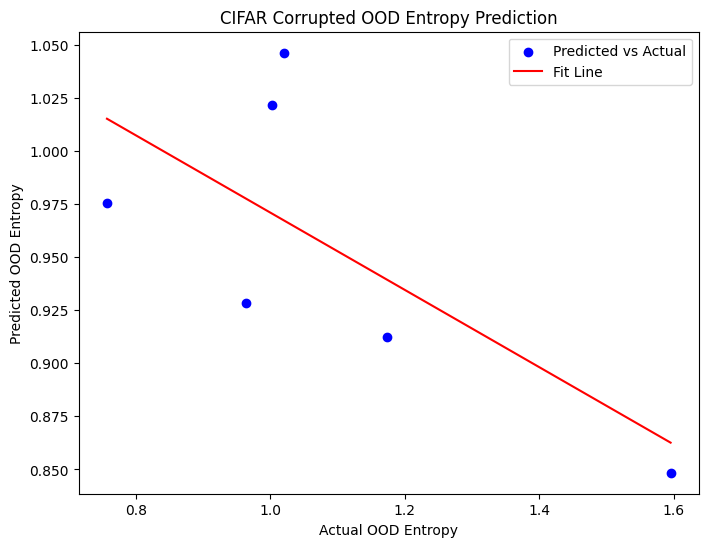

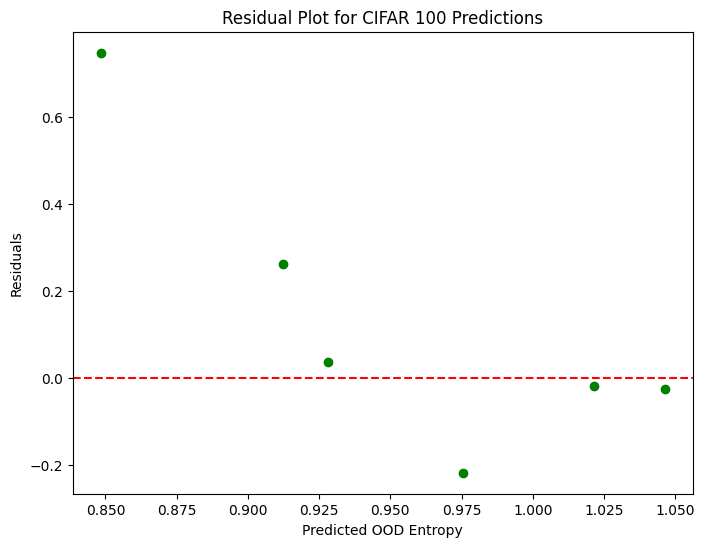

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `cifar_y_test` and `cifar_predicted_ood_ent` are already defined from the previous regression analysis

# Scatter Plot with Fit Line
plt.figure(figsize=(8, 6))
plt.scatter(cifar_y_test, cifar_predicted_ood_ent, color='blue', label='Predicted vs Actual')
plt.plot(np.unique(cifar_y_test), np.poly1d(np.polyfit(cifar_y_test, cifar_predicted_ood_ent, 1))(np.unique(cifar_y_test)), color='red', label='Fit Line')
plt.xlabel('Actual OOD Entropy')
plt.ylabel('Predicted OOD Entropy')
plt.title('CIFAR Corrupted OOD Entropy Prediction')
plt.legend()
plt.show()

# Residual Plot
residuals = cifar_y_test - cifar_predicted_ood_ent
plt.figure(figsize=(8, 6))
plt.scatter(cifar_predicted_ood_ent, residuals, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted OOD Entropy')
plt.ylabel('Residuals')
plt.title('Residual Plot for CIFAR 100 Predictions')
plt.show()


CIFAR100 Coefficients: [-0.009919    0.07833037 -0.03119088  0.01228059 -0.009919    0.00633555
  0.06272404  0.02941916]
CIFAR100 Intercept: 1.0489664942026138
CIFAR 100 R² Score: -86.28287725299462


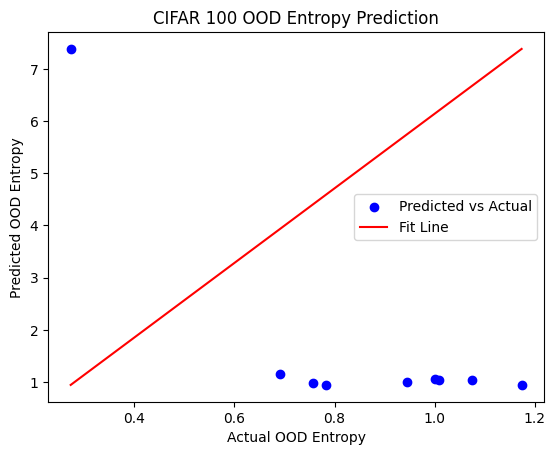

In [32]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare data
scaler = StandardScaler()
cifar_X_train, cifar_X_test, cifar_y_train, cifar_y_test = train_test_split(
    cifar_graph_metrics, cifar_ood_ent, test_size=0.3, random_state=20)

# Normalize features
cifar_X_train_scaled = scaler.fit_transform(cifar_X_train)
cifar_X_test_scaled = scaler.transform(cifar_X_test)

# Initialize Ridge regression model
cifar_model = Ridge(alpha=1.0)

# Fit the model
cifar_model.fit(cifar_X_train_scaled, cifar_y_train)

# Make predictions
cifar_predicted_ood_ent = cifar_model.predict(cifar_X_test_scaled)

# Print the coefficients and intercept
print("CIFAR100 Coefficients:", cifar_model.coef_)
print("CIFAR100 Intercept:", cifar_model.intercept_)

# Print R² score
cifar_r2 = r2_score(cifar_y_test, cifar_predicted_ood_ent)
print("CIFAR 100 R² Score:", cifar_r2)

# Visualization
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(cifar_y_test, cifar_predicted_ood_ent, color='blue', label='Predicted vs Actual')
plt.plot([min(cifar_y_test), max(cifar_y_test)], [min(cifar_predicted_ood_ent), max(cifar_predicted_ood_ent)], color='red', label='Fit Line')
plt.xlabel('Actual OOD Entropy')
plt.ylabel('Predicted OOD Entropy')
plt.title('CIFAR 100 OOD Entropy Prediction')
plt.legend()
plt.show()


Mean Squared Error: 0.09750901643438997
R² Score: -0.791487240788078


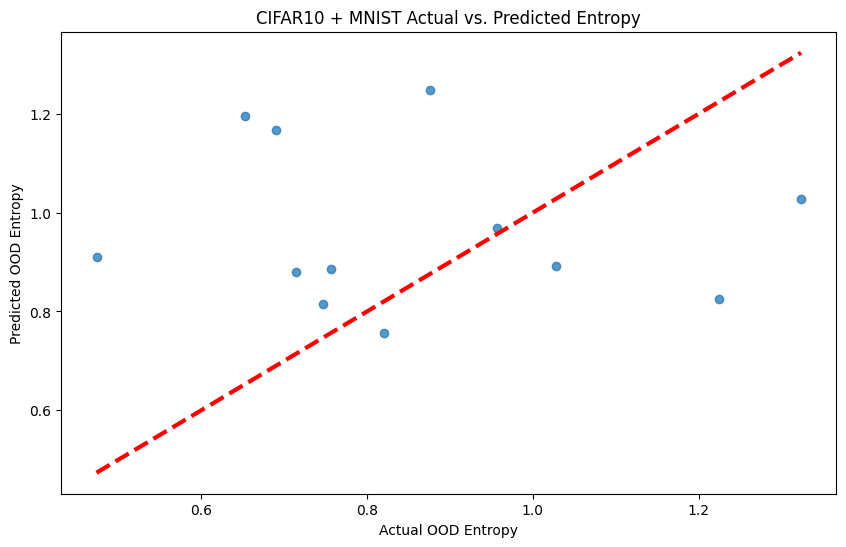

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming cifar_graph_metrics, mnist_graph_metrics, cifar_ood_ent, and mnist_ood_ent are already defined

# Combine the graph metrics and entropy values
combined_graph_metrics = np.concatenate((cifar_graph_metrics, mnist_graph_metrics), axis=0)
combined_ood_ent = np.concatenate((cifar_ood_ent, mnist_ood_ent), axis=0)

# Standardize the features
scaler = StandardScaler()
combined_graph_metrics_scaled = scaler.fit_transform(combined_graph_metrics)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_graph_metrics_scaled, combined_ood_ent, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
predicted_ood_ent = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predicted_ood_ent)
r2 = r2_score(y_test, predicted_ood_ent)

print("Mean Squared Error:", mse)
print("R² Score:", r2)

# Optionally, visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predicted_ood_ent, alpha=0.75)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.xlabel('Actual OOD Entropy')
plt.ylabel('Predicted OOD Entropy')
plt.title('CIFAR10 + MNIST Actual vs. Predicted Entropy')
plt.show()
